In [1]:
from classification_model.processing.data_management import load_dataset
train = load_dataset(file_name='AWID-CLS-R-Trn.csv')
test = load_dataset(file_name='AWID-CLS-R-Tst.csv')

C:\Users\skyst\Anaconda3\envs\tf\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
C:\Users\skyst\Anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (82,86,87,103,104,105,108,109,111,113,114,124,139,141,142,143,147) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\skyst\Anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (103,104,105,108,109,111,113,114,124,142,143) have mixed types.Specify dtype option on import or set low_memory=False.
  if (aw

In [2]:
from classification_model.processing.data_management import prepare_data
X_train, y_train = prepare_data(train, train_data=True)
X_test, y_test = prepare_data(test, train_data=False)

In [3]:
from classification_model.processing. data_management import load_pipeline
xgboost_pipe = load_pipeline(file_name='xgboost_classifier_model0.1.0.pkl')

In [4]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
y_train_pred = xgboost_pipe.predict(X_train)
print(classification_report(y_train, y_train_pred))

               precision    recall  f1-score   support

     flooding       0.73      1.00      0.84     48484
impersonation       0.95      1.00      0.97     48522
    injection       0.99      1.00      0.99     65379
       normal       1.00      0.99      0.99   1633189

     accuracy                           0.99   1795574
    macro avg       0.92      1.00      0.95   1795574
 weighted avg       0.99      0.99      0.99   1795574



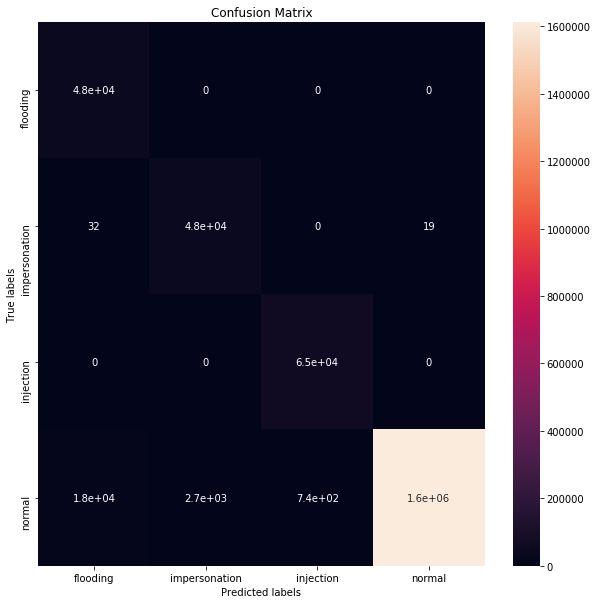

In [6]:
labels = ['flooding', 'impersonation', 'injection', 'normal']
cm = confusion_matrix(y_train, y_train_pred, labels)
plt.figure(figsize=(10,10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

In [7]:
y_test_pred = xgboost_pipe.predict(X_test)
print(classification_report(y_test, y_test_pred))

               precision    recall  f1-score   support

     flooding       0.79      0.72      0.75      8097
impersonation       0.80      0.07      0.13     20079
    injection       0.39      1.00      0.57     16682
       normal       1.00      0.98      0.99    530784

     accuracy                           0.95    575642
    macro avg       0.74      0.69      0.61    575642
 weighted avg       0.97      0.95      0.94    575642



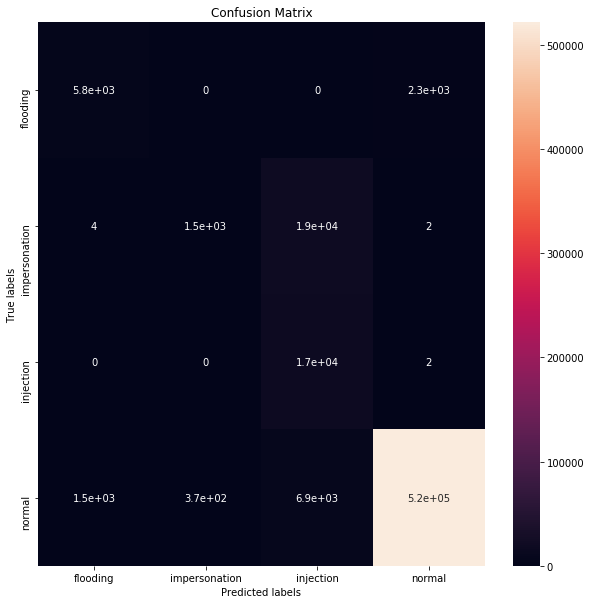

In [8]:
labels = ['flooding', 'impersonation', 'injection', 'normal']
cm = confusion_matrix(y_test, y_test_pred, labels)
plt.figure(figsize=(10,10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

In [9]:
from sklearn.pipeline import Pipeline

data_pipe = Pipeline(xgboost_pipe.steps[:-2])
data_pipe.steps

[('oc',
  outlier_capping(distribution='quantiles',
                  features=['frame.interface_id', 'frame.dlt',
                            'frame.offset_shift', 'frame.time_delta',
                            'frame.time_delta_displayed', 'frame.time_relative',
                            'frame.len', 'frame.cap_len', 'frame.marked',
                            'frame.ignored', 'radiotap.version', 'radiotap.pad',
                            'radiotap.length', 'radiotap.present.tsft',
                            'radiotap.present.flags', 'radiotap.prese...
                            'radiotap.present.dbm_antnoise',
                            'radiotap.present.lock_quality',
                            'radiotap.present.tx_attenuation',
                            'radiotap.present.db_tx_attenuation',
                            'radiotap.present.dbm_tx_power',
                            'radiotap.present.antenna',
                            'radiotap.present.db_antsignal',
     

In [10]:
X_train_trans = data_pipe.transform(X_train)

In [11]:
import pandas as pd
feature_importance = pd.DataFrame()
feature_importance['feature'] = X_train_trans.columns
feature_importance

,feature
0,frame.time_delta
1,frame.time_relative
2,frame.len
3,radiotap.flags.cfp
4,wlan.fc.type_subtype
...,...
37,wlan.ra_passed1second_count
38,wlan.da_passed1second_count
39,wlan.wep.iv_passed1second_count_change
40,wlan.ta_passed1second_count_change


In [12]:
pd.set_option('display.max_rows', 500)
feature_importance['importance'] = xgboost_pipe.named_steps['xgb'].feature_importances_


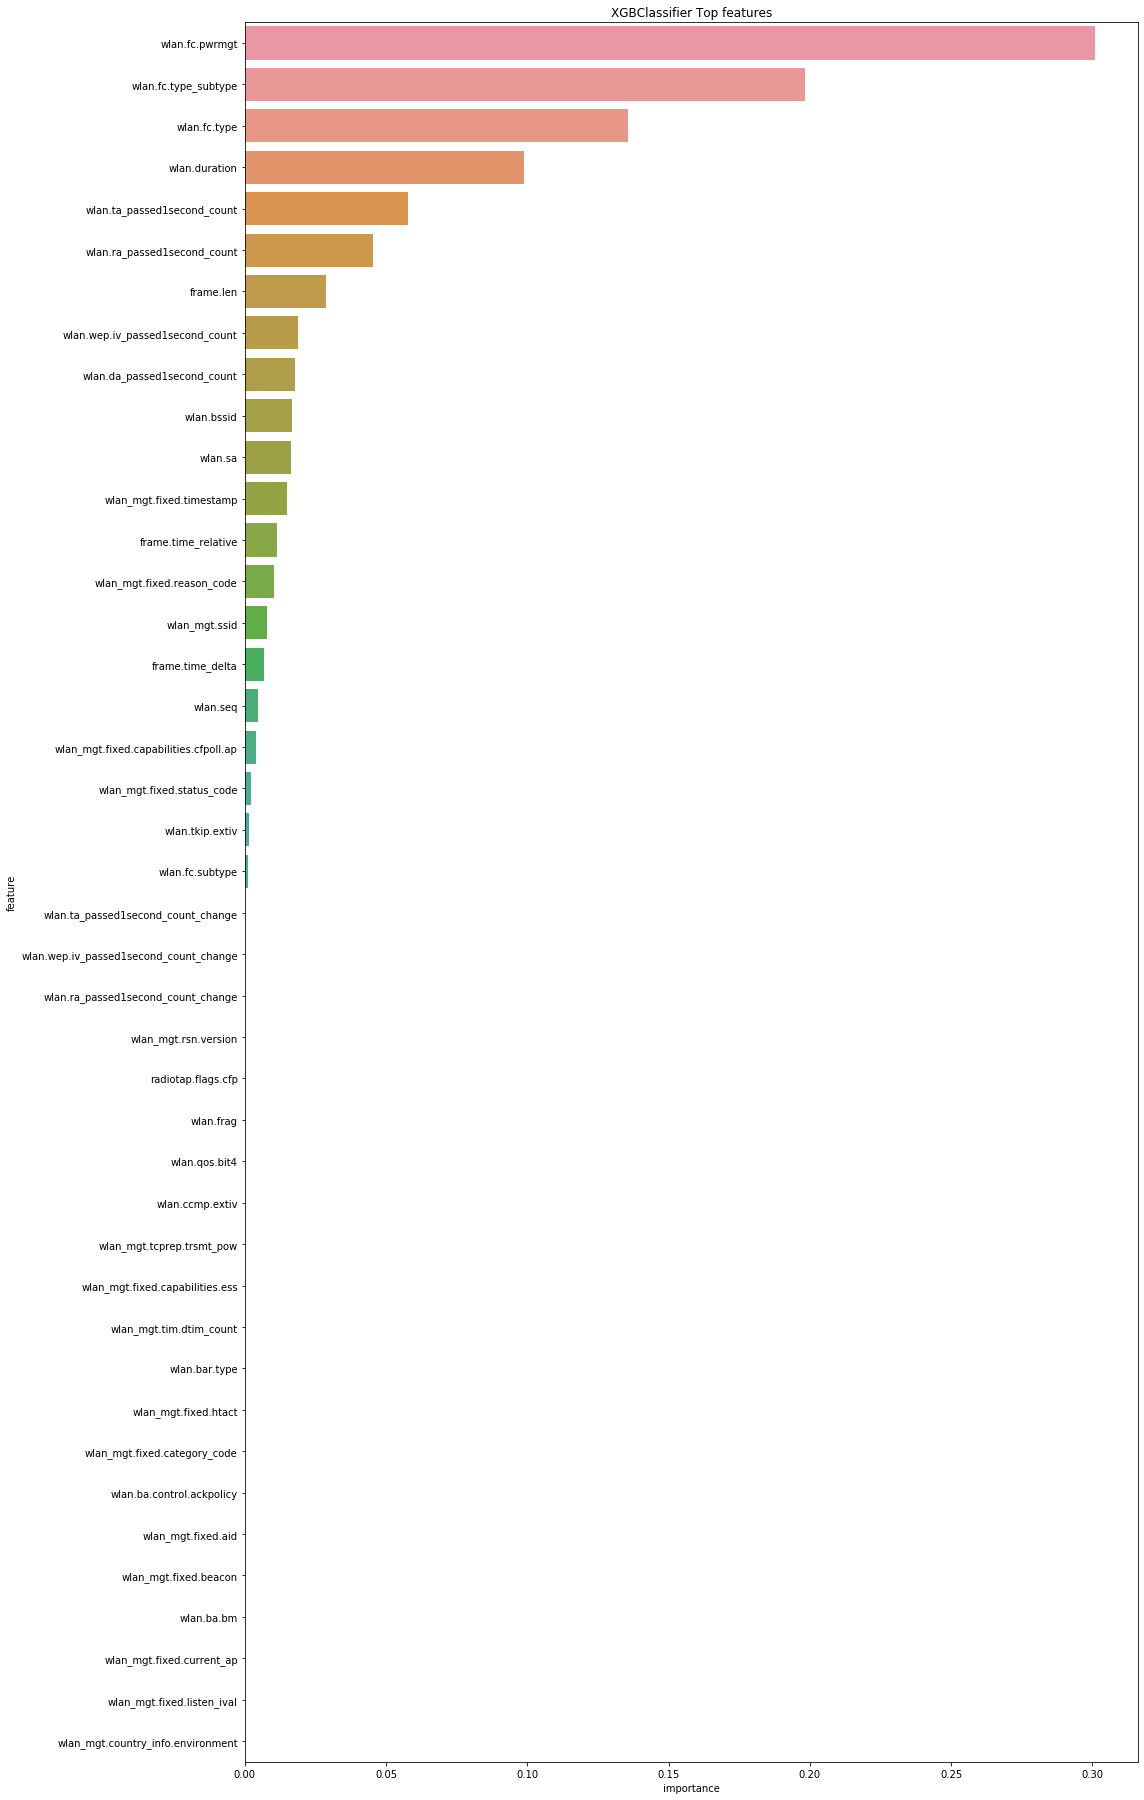

In [13]:
plt.figure(figsize=(16, 32))
sns.barplot(data=feature_importance.sort_values(by='importance', ascending=False), x='importance', y='feature');
plt.title('XGBClassifier Top features');

In [14]:
X_test_bad = X_test[y_test != y_test_pred]
y_test_bad = y_test[y_test != y_test_pred]
X_test_bad = data_pipe.transform(X_test_bad)
X_test_bad['class'] = y_test_bad
X_test_bad['frame.time_epoch'] = X_test['frame.time_epoch']

In [15]:
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import seaborn as sns
from scipy import stats
import numpy as np
import pandas as pd

In [16]:
from classification_model.processing.feat_eng_categ import one_hot_encoder
ohe = one_hot_encoder(features='class')
X_test_bad = ohe.fit_transform(X_test_bad)

In [17]:
def h(content):
    display(HTML(content))
    
def timehist(df, tcol, target, col, target_first, clipping=9999999999999999, concat_df = False, odf = None):
    if concat_df == True:
        df = pd.concat([df, odf])
        
    title = target + ' Hist ' + col
    if( target_first==True):
        df[df[target] == 1].set_index(tcol)[col].clip(0, clipping).plot(style='.', figsize=(15, 3))
        df[df[target] == 0].set_index(tcol)[col].clip(0, clipping).plot(style='.', figsize=(15, 3))
        plt.title(title)
        plt.show()
    elif( target_first==False):
        df[df[target] == 0].set_index(tcol)[col].clip(0, clipping).plot(style='.', title= title, figsize=(15, 3))
        df[df[target] == 1].set_index(tcol)[col].clip(0, clipping).plot(style='.', title= title, figsize=(15, 3))
        plt.title(title)
        plt.show()

In [18]:
def _desc(data, col, label):
    d0 = data.describe().reset_index()
    d0.columns = [col, label]
    return d0.append({col:'unique values', label:data.unique().shape[0]}, ignore_index=True) \
             .append({col:'NaNs', label:data.isnull().sum()}, ignore_index=True) \
             .append({col:'NaNs share', label:np.round(data.isnull().sum() / data.shape[0], 4)}, ignore_index=True) \

def desc(df_train, col, target, include_test=False, df_test=None):
    d0 = _desc(df_train[col], col, 'Train')
    d1 = _desc(df_train.loc[df_train[target] == 1, col], col, 'Train normal')
    d2 = _desc(df_train.loc[df_train[target] == 0, col], col, 'Train not normal')
    if( include_test):
        d3 = _desc(df_test[col], col, 'Test')
        d4 = _desc(df_test.loc[df_test[target] == 1, col], col, 'Test normal')
        d5 = _desc(df_test.loc[df_test[target] == 0, col], col, 'Test not normal')
    if( include_test):
        dd = d0.merge(d1).merge(d2).merge(d3).merge(d4).merge(d5)
    else:
        dd = d0.merge(d1).merge(d2)
    display(dd)
    
    h('<b>Most popular values (NaN = -999):</b>')
    N = 10
    d0 = df_train[[target,col]].groupby(col)[target].agg(['size','mean','sum']).reset_index().sort_values('size', ascending=False).reset_index(drop=True)
    d0 = d0.head(N)
    d0 = d0.rename({'size':'Count in train (desc)','mean':'Mean target train','sum':'Sum target train'}, axis=1)
    display(d0)
    
    if( include_test):
        d1 = df_test[[target,col]].groupby(col)[target].agg(['size','mean','sum']).reset_index().sort_values('size', ascending=False).reset_index(drop=True)
        d1 = d1.head(N)
        d1 = d1.rename({'size':'Count in test (desc)','mean':'Mean target test','sum':'Sum target test'}, axis=1)
        display(d1)

In [19]:
def hist1(df,col):
    plt.figure(figsize=(15, 3))
    plt.hist(df[col], bins=70);
    plt.title('Train histogram: ' + col);
    plt.show()

In [20]:
def corr1(df,col):
    N = None #10000
    num_vars = [f for f in df.columns if df[f].dtype != 'object']
    trx = df.head(N) if N is not None else df.copy()
    corrs = trx[num_vars].corrwith(trx[col]).reset_index().sort_values(0, ascending=False).reset_index(drop=True).rename({'index':'Column',0:'Correlation with ' + col}, axis=1)
    h('<b>Most correlated values with ' + col + ':</b>')
    trx = pd.concat([corrs.head(6), corrs.dropna().tail(5)])
    def linkx(val):
        return '<a href="#c_{}">{}</a>'.format(val, val)
    trx['Column'] = trx['Column'].apply(linkx)
    h(trx.to_html(escape=False))

In [21]:
def numeric(df_input, tcol_input, target_input, col_input, target_first_input, df_test, include_test):
    timehist(df=df_input, tcol=tcol_input, target=target_input, col=col_input, target_first=target_first_input, odf=df_test, concat_df=include_test)
    hist1(df_input,col_input)
    desc(df_input, col_input, target_input, include_test, df_test)
    corr1(df_input,col_input)

In [22]:
def categorical(df, col, target, df_test, include_test):
    desc(df, col, target, include_test, df_test)

In [23]:
def proc(df, tcol, target, col, target_first, df_test, include_test):
    if col not in ['isFraud','TransactionDT']:
        h('<h3 id="c_' + col + '">' + col + '</h3>' + '<a style="font-size:11px" href="#home">(Jump to top)</a>')
        categorical(df, col, target, df_test, include_test) if df[col].dtype == 'object' else numeric(df, tcol, target, col, target_first, df_test, include_test)

In [24]:
columns = list(X_test_bad.columns)
for x in ['frame.time_epoch', 'class_normal', 'class_injection', 'class_impersonation', 'class_flooding']:
    columns.remove(x)

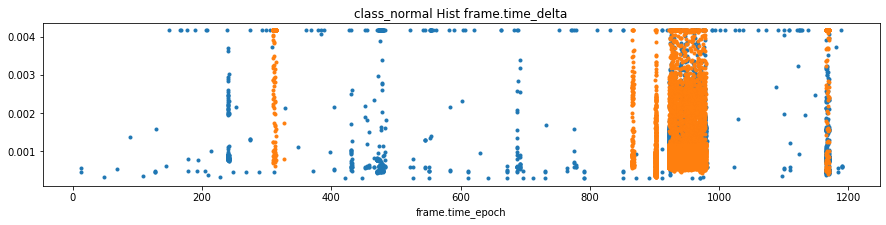

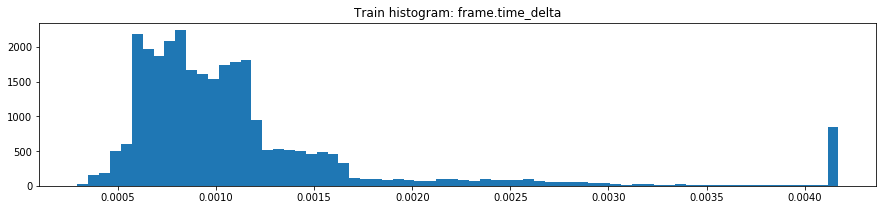

,frame.time_delta,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.000000
1,mean,0.001142,0.001462,0.001006
2,std,0.000724,0.000831,0.000626
3,min,0.000294,0.000294,0.000320
4,25%,0.000735,0.001052,0.000687
5,50%,0.000952,0.001287,0.000856
6,75%,0.001191,0.001554,0.001057
7,max,0.004172,0.004172,0.004172
8,unique values,2571.000000,1767.000000,2014.000000
9,NaNs,0.000000,0.000000,0.000000


,frame.time_delta,Count in train (desc),Mean target train,Sum target train
0,0.004172,842,0.587886,495
1,0.000809,102,0.372549,38
2,0.000771,94,0.117021,11
3,0.000750,90,0.022222,2
4,0.001031,85,0.129412,11
5,0.000650,78,0.012821,1
6,0.000810,77,0.337662,26
7,0.001069,77,0.220779,17
8,0.000931,75,0.013333,1
9,0.000788,73,0.205479,15


,Column,Correlation with frame.time_delta
0,frame.time_delta,1.000000
1,frame.len,0.482212
2,class_normal,0.287971
3,wlan.fc.pwrmgt,0.183731
4,wlan.sa,0.171159
5,wlan.bssid,0.121337
35,wlan.wep.iv_passed1second_count,-0.153431
36,wlan.da_passed1second_count,-0.192512
37,wlan.ra_passed1second_count,-0.195327
38,wlan.ta_passed1second_count,-0.220783


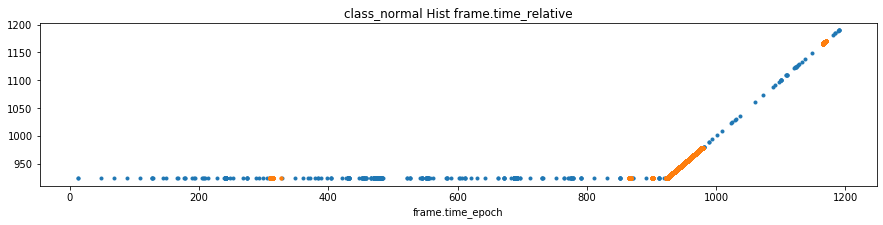

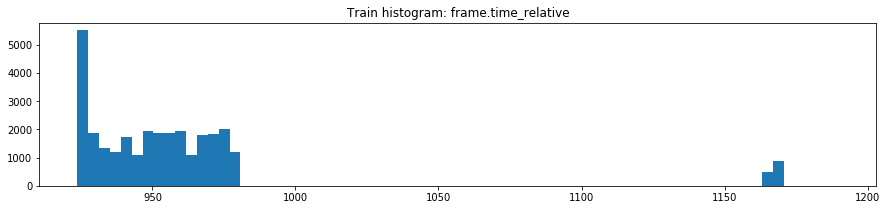

,frame.time_relative,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.000000
1,mean,959.121191,979.811327,950.362000
2,std,49.742499,77.852577,26.422197
3,min,923.778728,923.778728,923.778728
4,25%,931.492610,934.794863,930.977166
5,50%,950.832881,953.625421,949.514138
6,75%,967.520658,973.071561,965.358486
7,max,1189.754864,1189.754864,1170.511338
8,unique values,26485.000000,8077.000000,18409.000000
9,NaNs,0.000000,0.000000,0.000000


,frame.time_relative,Count in train (desc),Mean target train,Sum target train
0,923.778728,3274,0.236714,775
1,962.999157,1,0.000000,0
2,963.077561,1,1.000000,1
3,963.064595,1,0.000000,0
4,963.046746,1,1.000000,1
5,963.033523,1,0.000000,0
6,963.032279,1,0.000000,0
7,963.031299,1,0.000000,0
8,963.028868,1,1.000000,1
9,963.014461,1,0.000000,0


,Column,Correlation with frame.time_relative
0,frame.time_relative,1.000000
1,wlan_mgt.fixed.reason_code,0.858623
2,wlan.seq,0.679154
3,frame.time_epoch,0.548268
4,wlan.fc.type_subtype,0.487166
5,wlan.fc.subtype,0.413410
35,wlan.ra_passed1second_count,-0.225316
36,wlan.da_passed1second_count,-0.263205
37,wlan.ta_passed1second_count,-0.341728
38,wlan.sa,-0.486924


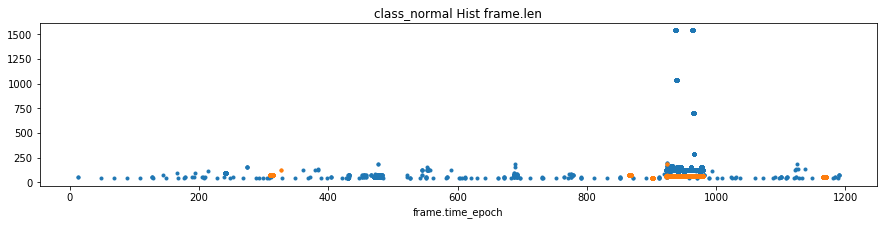

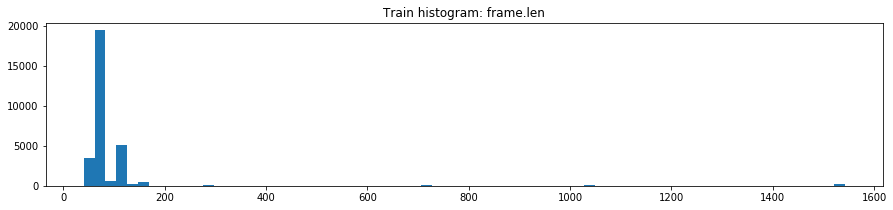

,frame.len,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.000000
1,mean,90.376470,152.931872,63.893576
2,std,128.174708,222.564540,7.536474
3,min,40.000000,40.000000,40.000000
4,25%,66.000000,98.000000,66.000000
5,50%,66.000000,124.000000,66.000000
6,75%,72.000000,124.000000,66.000000
7,max,1542.000000,1542.000000,190.000000
8,unique values,40.000000,36.000000,9.000000
9,NaNs,0.000000,0.000000,0.000000


,frame.len,Count in train (desc),Mean target train,Sum target train
0,66.0,18606,0.000000,0
1,124.0,5090,0.999804,5089
2,40.0,1783,0.013460,24
3,56.0,1305,1.000000,1305
4,98.0,611,1.000000,611
5,75.0,369,0.000000,0
6,72.0,339,1.000000,339
7,161.0,265,1.000000,265
8,166.0,178,1.000000,178
9,136.0,168,1.000000,168


,Column,Correlation with frame.len
0,frame.len,1.000000
1,frame.time_delta,0.482212
2,class_normal,0.317556
3,wlan.frag,0.101004
4,wlan.fc.type,0.100438
5,wlan.duration,0.082337
35,wlan.da_passed1second_count,-0.122842
36,wlan.ra_passed1second_count,-0.123871
37,wlan.ta_passed1second_count,-0.130588
38,wlan.wep.iv_passed1second_count,-0.159078


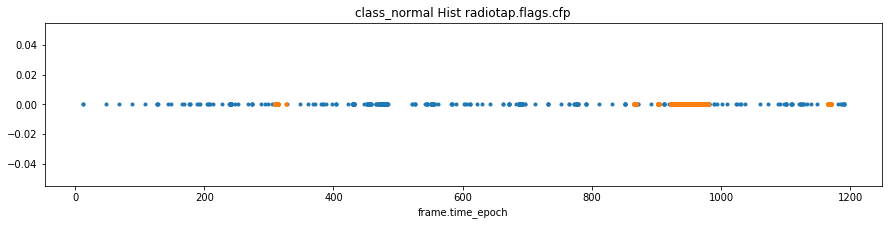

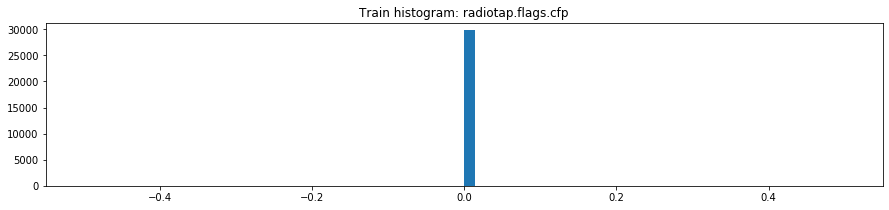

,radiotap.flags.cfp,Train,Train normal,Train not normal
0,count,29758.0,8851.0,20907.0
1,mean,0.0,0.0,0.0
2,std,0.0,0.0,0.0
3,min,0.0,0.0,0.0
4,25%,0.0,0.0,0.0
5,50%,0.0,0.0,0.0
6,75%,0.0,0.0,0.0
7,max,0.0,0.0,0.0
8,unique values,1.0,1.0,1.0
9,NaNs,0.0,0.0,0.0


,radiotap.flags.cfp,Count in train (desc),Mean target train,Sum target train
0,0.0,29758,0.297433,8851


,Column,Correlation with radiotap.flags.cfp
0,frame.time_delta,NaN
1,frame.time_relative,NaN
2,frame.len,NaN
3,radiotap.flags.cfp,NaN
4,wlan.fc.type_subtype,NaN
5,wlan.fc.type,NaN


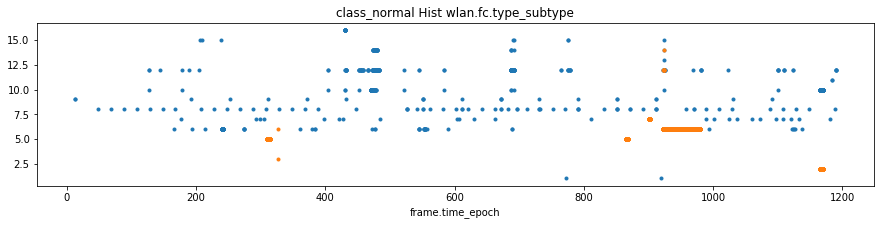

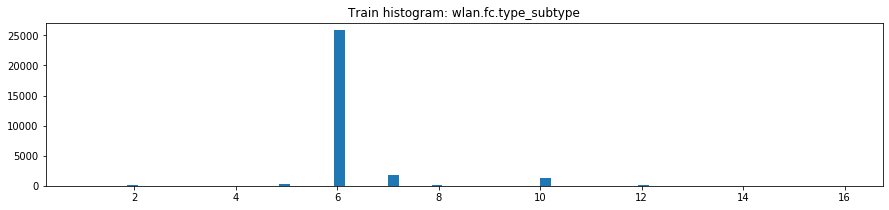

,wlan.fc.type_subtype,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.000000
1,mean,6.260703,6.790080,6.036591
2,std,1.086652,1.734136,0.488704
3,min,1.000000,1.000000,2.000000
4,25%,6.000000,6.000000,6.000000
5,50%,6.000000,6.000000,6.000000
6,75%,6.000000,6.000000,6.000000
7,max,16.000000,16.000000,14.000000
8,unique values,15.000000,12.000000,7.000000
9,NaNs,0.000000,0.000000,0.000000


,wlan.fc.type_subtype,Count in train (desc),Mean target train,Sum target train
0,6,25808,0.279022,7201
1,7,1783,0.013460,24
2,10,1281,1.000000,1281
3,5,369,0.000000,0
4,12,206,0.975728,201
5,2,165,0.000000,0
6,8,67,1.000000,67
7,14,31,0.967742,30
8,9,22,1.000000,22
9,16,12,1.000000,12


,Column,Correlation with wlan.fc.type_subtype
0,wlan.fc.type_subtype,1.000000
1,wlan_mgt.fixed.reason_code,0.726906
2,wlan.fc.subtype,0.698231
3,frame.time_relative,0.487166
4,wlan_mgt.fixed.status_code,0.485044
5,wlan.seq,0.349691
35,wlan.frag,-0.198120
36,wlan.ta_passed1second_count,-0.268177
37,class_impersonation,-0.307599
38,wlan.sa,-0.573575


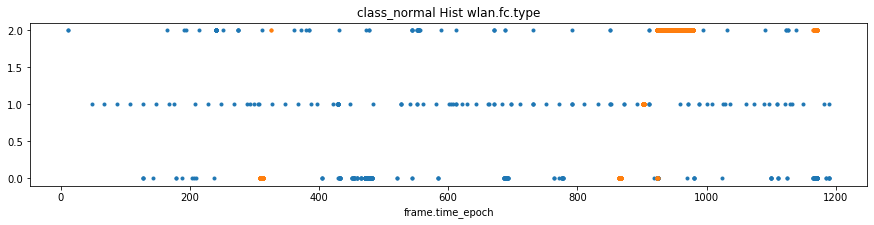

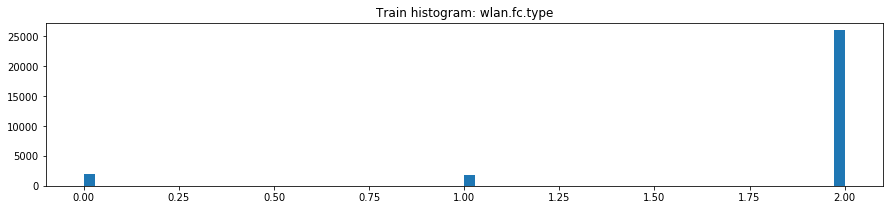

,wlan.fc.type,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.000000
1,mean,1.809732,1.643769,1.879992
2,std,0.530822,0.757621,0.376146
3,min,0.000000,0.000000,0.000000
4,25%,2.000000,2.000000,2.000000
5,50%,2.000000,2.000000,2.000000
6,75%,2.000000,2.000000,2.000000
7,max,2.000000,2.000000,2.000000
8,unique values,3.000000,3.000000,3.000000
9,NaNs,0.000000,0.000000,0.000000


,wlan.fc.type,Count in train (desc),Mean target train,Sum target train
0,2.0,25996,0.277850,7223
1,0.0,1900,0.802632,1525
2,1.0,1862,0.055317,103


,Column,Correlation with wlan.fc.type
0,wlan.fc.type,1.000000
1,wlan.sa,0.556668
2,class_impersonation,0.461623
3,wlan.duration,0.433938
4,wlan.frag,0.394111
5,wlan.ta_passed1second_count,0.384152
35,wlan.bssid,-0.511475
36,frame.time_relative,-0.517124
37,wlan_mgt.fixed.reason_code,-0.719878
38,wlan.fc.type_subtype,-0.768852


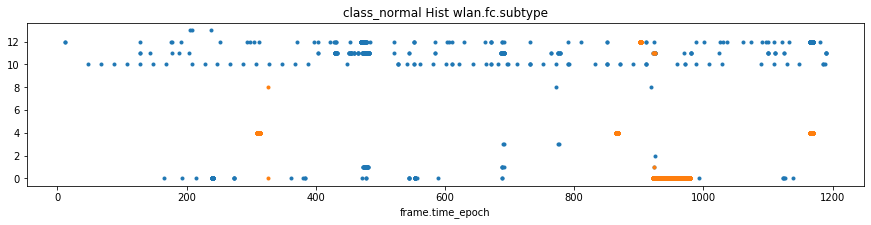

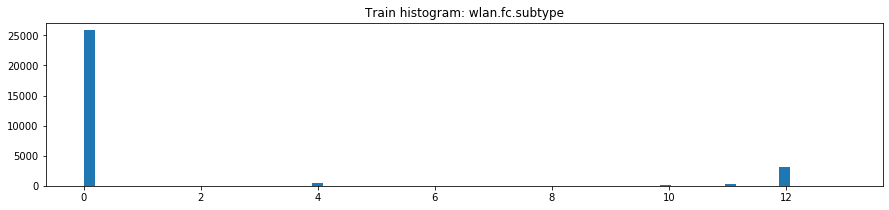

,wlan.fc.subtype,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.000000
1,mean,1.423617,2.152977,1.114842
2,std,3.786600,4.552753,3.363592
3,min,0.000000,0.000000,0.000000
4,25%,0.000000,0.000000,0.000000
5,50%,0.000000,0.000000,0.000000
6,75%,0.000000,0.000000,0.000000
7,max,13.000000,13.000000,12.000000
8,unique values,10.000000,9.000000,6.000000
9,NaNs,0.000000,0.000000,0.000000


,wlan.fc.subtype,Count in train (desc),Mean target train,Sum target train
0,0.0,25809,0.279050,7202
1,12.0,3086,0.430006,1327
2,4.0,534,0.000000,0
3,11.0,218,0.977064,213
4,10.0,69,1.000000,69
5,1.0,31,0.967742,30
6,3.0,4,1.000000,4
7,8.0,3,0.666667,2
8,13.0,3,1.000000,3
9,2.0,1,1.000000,1


,Column,Correlation with wlan.fc.subtype
0,wlan.fc.subtype,1.000000
1,wlan.fc.type_subtype,0.698231
2,class_flooding,0.664896
3,wlan_mgt.fixed.reason_code,0.589591
4,wlan.bssid,0.496031
5,frame.time_relative,0.413410
35,class_impersonation,-0.484807
36,wlan.duration,-0.576914
37,wlan.sa,-0.657857
38,wlan.frag,-0.716279


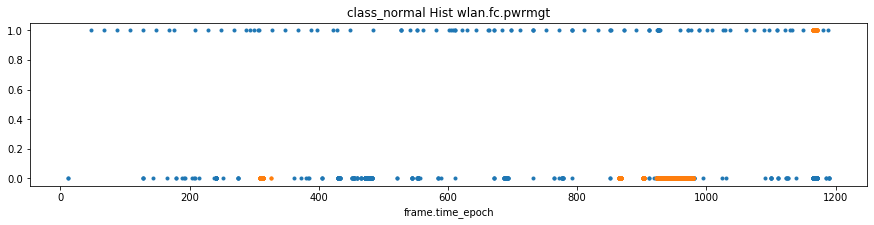

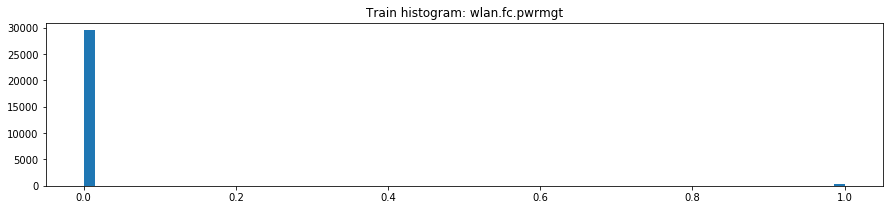

,wlan.fc.pwrmgt,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.000000
1,mean,0.009107,0.011976,0.007892
2,std,0.094996,0.108784,0.088488
3,min,0.000000,0.000000,0.000000
4,25%,0.000000,0.000000,0.000000
5,50%,0.000000,0.000000,0.000000
6,75%,0.000000,0.000000,0.000000
7,max,1.000000,1.000000,1.000000
8,unique values,2.000000,2.000000,2.000000
9,NaNs,0.000000,0.000000,0.000000


,wlan.fc.pwrmgt,Count in train (desc),Mean target train,Sum target train
0,0.0,29487,0.296571,8745
1,1.0,271,0.391144,106


,Column,Correlation with wlan.fc.pwrmgt
0,wlan.fc.pwrmgt,1.000000
1,frame.time_relative,0.240639
2,class_flooding,0.191175
3,frame.time_delta,0.183731
4,wlan.fc.subtype,0.115117
5,frame.time_epoch,0.038173
35,wlan.da_passed1second_count,-0.159399
36,wlan.ra_passed1second_count,-0.162762
37,wlan.fc.type_subtype,-0.186426
38,wlan.ta_passed1second_count,-0.269212


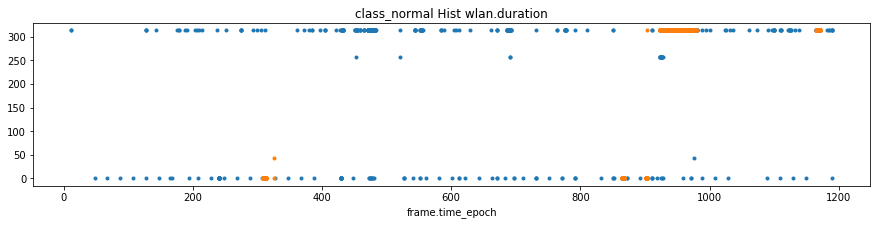

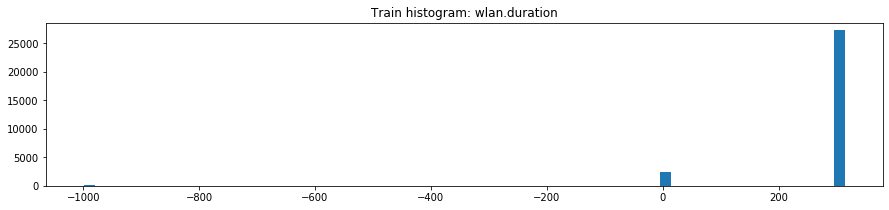

,wlan.duration,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.000000
1,mean,285.512232,293.745001,282.026881
2,std,105.241417,125.870984,94.958634
3,min,-999.000000,-999.000000,0.000000
4,25%,314.000000,314.000000,314.000000
5,50%,314.000000,314.000000,314.000000
6,75%,314.000000,314.000000,314.000000
7,max,314.000000,314.000000,314.000000
8,unique values,5.000000,5.000000,3.000000
9,NaNs,0.000000,0.000000,0.000000


,wlan.duration,Count in train (desc),Mean target train,Sum target train
0,314.0,27253,0.310975,8475
1,0.0,2414,0.118476,286
2,-999.0,67,1.000000,67
3,258.0,22,1.000000,22
4,44.0,2,0.500000,1


,Column,Correlation with wlan.duration
0,wlan.duration,1.000000
1,wlan.frag,0.778810
2,wlan.seq,0.649868
3,frame.time_epoch,0.436091
4,wlan.fc.type,0.433938
5,class_impersonation,0.349797
35,wlan.da_passed1second_count,-0.265794
36,wlan.fc.pwrmgt,-0.273298
37,wlan.fc.subtype,-0.576914
38,wlan.bssid,-0.652601


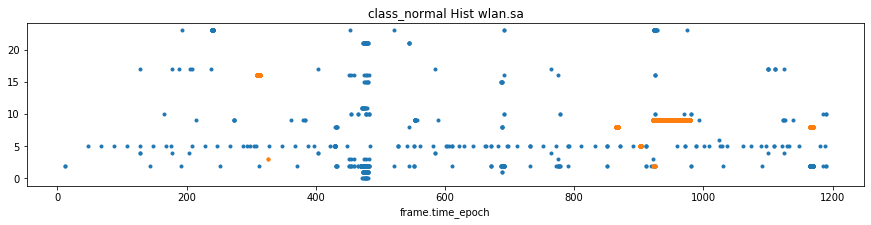

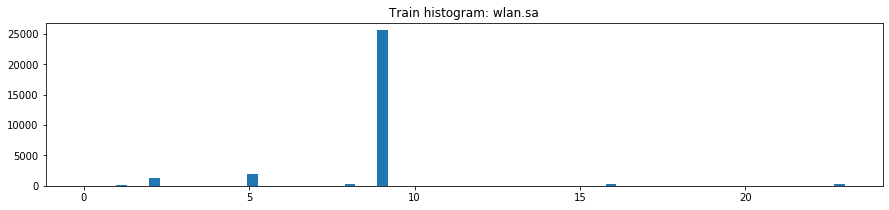

,wlan.sa,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.000000
1,mean,8.605585,8.343690,8.716459
2,std,2.385643,3.846673,1.340006
3,min,0.000000,0.000000,2.000000
4,25%,9.000000,9.000000,9.000000
5,50%,9.000000,9.000000,9.000000
6,75%,9.000000,9.000000,9.000000
7,max,23.000000,23.000000,16.000000
8,unique values,16.000000,16.000000,6.000000
9,NaNs,0.000000,0.000000,0.000000


,wlan.sa,Count in train (desc),Mean target train,Sum target train
0,9,25520,0.270925,6914
1,5,1862,0.055317,103
2,2,1354,0.995569,1348
3,8,333,0.033033,11
4,23,285,1.000000,285
5,16,224,0.053571,12
6,1,54,1.000000,54
7,21,29,1.000000,29
8,10,24,1.000000,24
9,17,17,1.000000,17


,Column,Correlation with wlan.sa
0,wlan.sa,1.000000
1,wlan.fc.type,0.556668
2,wlan.frag,0.390478
3,class_impersonation,0.212422
4,frame.time_delta,0.171159
5,wlan.duration,0.091119
35,frame.time_relative,-0.486924
36,wlan.fc.type_subtype,-0.573575
37,wlan_mgt.fixed.reason_code,-0.575954
38,frame.time_epoch,-0.585631


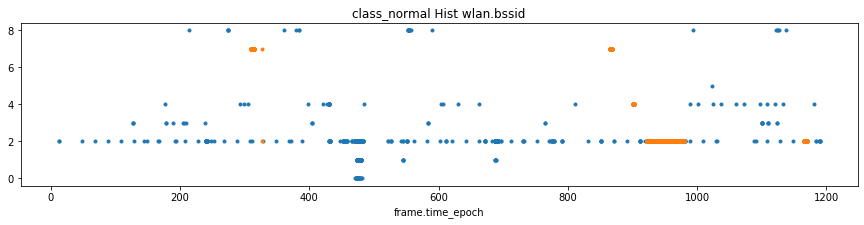

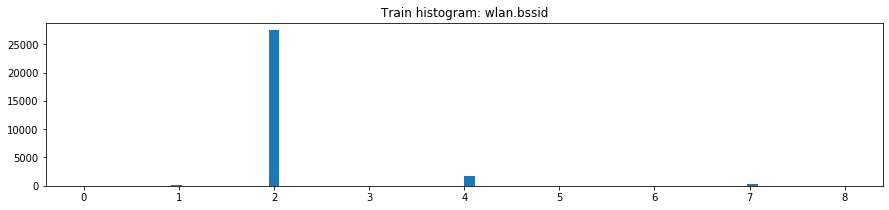

,wlan.bssid,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.000000
1,mean,2.185160,2.016043,2.256756
2,std,0.748553,0.398546,0.844443
3,min,0.000000,0.000000,2.000000
4,25%,2.000000,2.000000,2.000000
5,50%,2.000000,2.000000,2.000000
6,75%,2.000000,2.000000,2.000000
7,max,8.000000,8.000000,7.000000
8,unique values,8.000000,7.000000,3.000000
9,NaNs,0.000000,0.000000,0.000000


,wlan.bssid,Count in train (desc),Mean target train,Sum target train
0,2,27424,0.315271,8646
1,4,1795,0.020056,36
2,7,370,0.000000,0
3,1,87,1.000000,87
4,8,29,1.000000,29
5,3,28,1.000000,28
6,0,24,1.000000,24
7,5,1,1.000000,1


,Column,Correlation with wlan.bssid
0,wlan.bssid,1.000000
1,class_flooding,0.831346
2,wlan.fc.subtype,0.496031
3,wlan.tkip.extiv,0.208048
4,wlan.da_passed1second_count,0.143932
5,wlan.ta_passed1second_count_change,0.139984
35,frame.time_epoch,-0.355189
36,wlan.fc.type,-0.511475
37,wlan.seq,-0.588364
38,wlan.frag,-0.601547


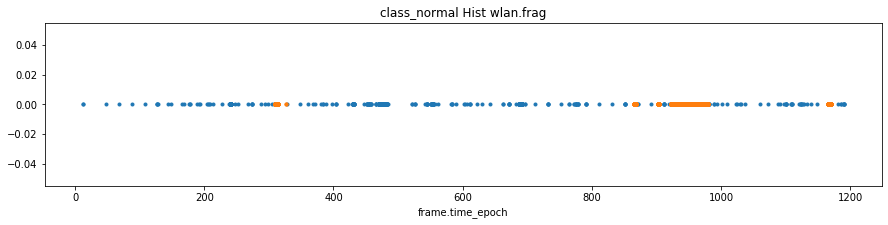

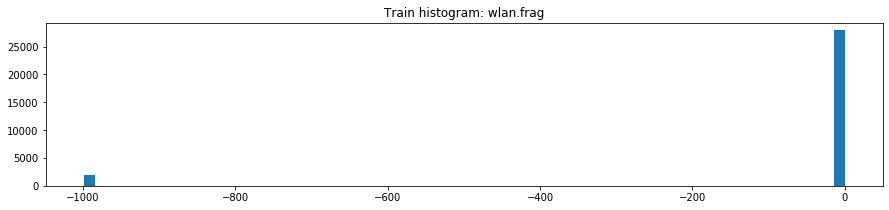

,wlan.frag,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.000000
1,mean,-62.508838,-11.625466,-84.050366
2,std,241.952354,107.144697,277.318463
3,min,-999.000000,-999.000000,-999.000000
4,25%,0.000000,0.000000,0.000000
5,50%,0.000000,0.000000,0.000000
6,75%,0.000000,0.000000,0.000000
7,max,0.000000,0.000000,0.000000
8,unique values,2.000000,2.000000,2.000000
9,NaNs,0.000000,0.000000,0.000000


,wlan.frag,Count in train (desc),Mean target train,Sum target train
0,0.0,27896,0.313593,8748
1,-999.0,1862,0.055317,103


,Column,Correlation with wlan.frag
0,wlan.frag,1.000000
1,wlan.duration,0.778810
2,wlan.seq,0.731883
3,wlan.fc.type,0.394111
4,wlan.sa,0.390478
5,class_impersonation,0.333853
35,wlan.ra_passed1second_count,-0.377047
36,wlan.da_passed1second_count,-0.436976
37,wlan.bssid,-0.601547
38,wlan.fc.subtype,-0.716279


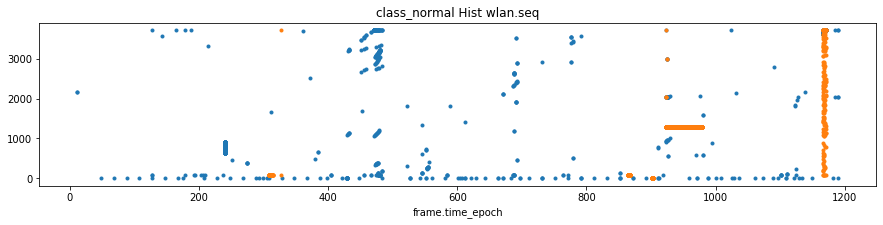

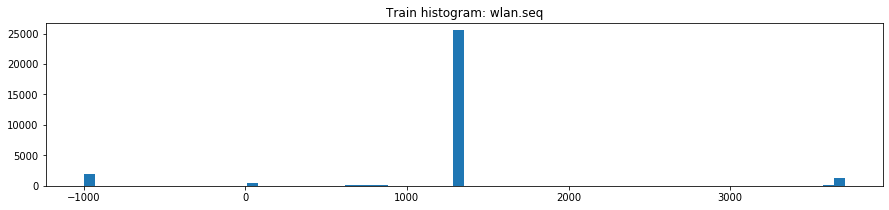

,wlan.seq,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.000000
1,mean,1242.214531,1612.227997,1085.568948
2,std,791.166891,930.752357,664.623476
3,min,-999.000000,-999.000000,-999.000000
4,25%,1293.000000,1293.000000,1293.000000
5,50%,1293.000000,1293.000000,1293.000000
6,75%,1293.000000,1293.000000,1293.000000
7,max,3708.000000,3708.000000,3708.000000
8,unique values,705.000000,579.000000,149.000000
9,NaNs,0.000000,0.000000,0.000000


,wlan.seq,Count in train (desc),Mean target train,Sum target train
0,1293.0,25491,0.270095,6885
1,-999.0,1862,0.055317,103
2,3708.0,852,0.980047,835
3,76.0,428,0.119159,51
4,3688.0,8,1.000000,8
5,3666.0,8,1.000000,8
6,3681.0,8,0.875000,7
7,3676.0,7,1.000000,7
8,3687.0,7,1.000000,7
9,3686.0,7,1.000000,7


,Column,Correlation with wlan.seq
0,wlan.seq,1.000000
1,wlan.frag,0.731883
2,frame.time_relative,0.679154
3,wlan.duration,0.649868
4,wlan_mgt.fixed.reason_code,0.645552
5,frame.time_epoch,0.405444
35,wlan.ta_passed1second_count,-0.320257
36,wlan.ra_passed1second_count,-0.361816
37,wlan.da_passed1second_count,-0.426951
38,wlan.bssid,-0.588364


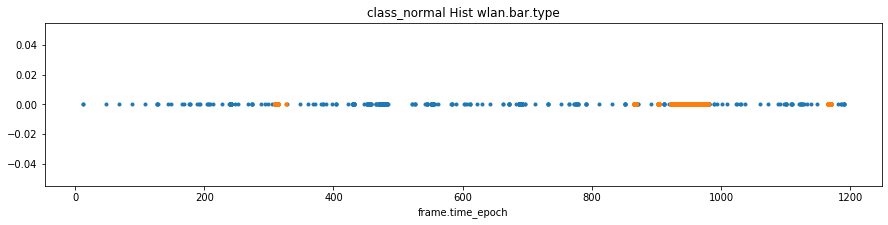

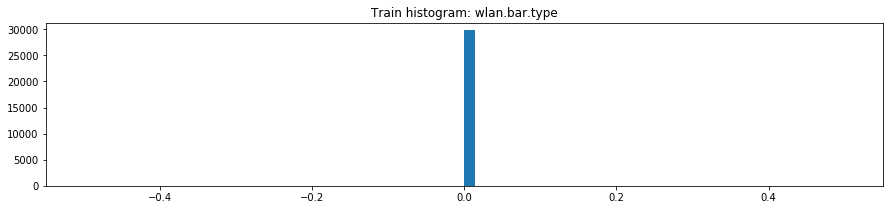

,wlan.bar.type,Train,Train normal,Train not normal
0,count,29758.0,8851.0,20907.0
1,mean,0.0,0.0,0.0
2,std,0.0,0.0,0.0
3,min,0.0,0.0,0.0
4,25%,0.0,0.0,0.0
5,50%,0.0,0.0,0.0
6,75%,0.0,0.0,0.0
7,max,0.0,0.0,0.0
8,unique values,1.0,1.0,1.0
9,NaNs,0.0,0.0,0.0


,wlan.bar.type,Count in train (desc),Mean target train,Sum target train
0,0,29758,0.297433,8851


,Column,Correlation with wlan.bar.type
0,frame.time_delta,NaN
1,frame.time_relative,NaN
2,frame.len,NaN
3,radiotap.flags.cfp,NaN
4,wlan.fc.type_subtype,NaN
5,wlan.fc.type,NaN


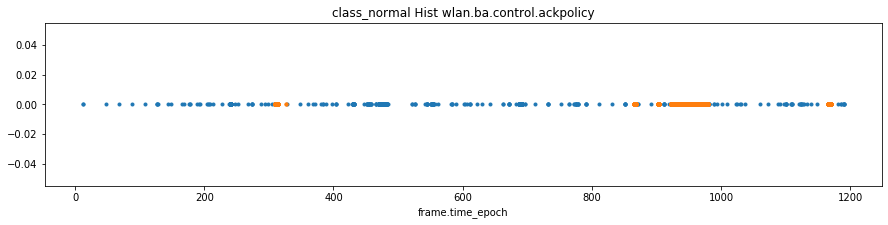

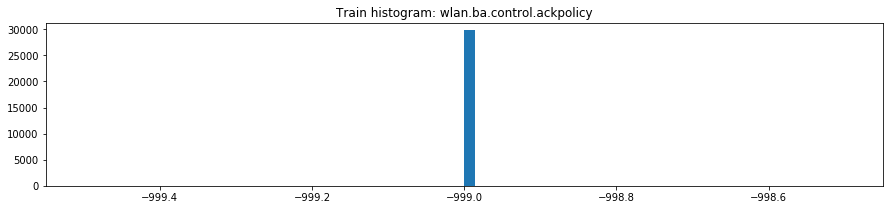

,wlan.ba.control.ackpolicy,Train,Train normal,Train not normal
0,count,29758.0,8851.0,20907.0
1,mean,-999.0,-999.0,-999.0
2,std,0.0,0.0,0.0
3,min,-999.0,-999.0,-999.0
4,25%,-999.0,-999.0,-999.0
5,50%,-999.0,-999.0,-999.0
6,75%,-999.0,-999.0,-999.0
7,max,-999.0,-999.0,-999.0
8,unique values,1.0,1.0,1.0
9,NaNs,0.0,0.0,0.0


,wlan.ba.control.ackpolicy,Count in train (desc),Mean target train,Sum target train
0,-999.0,29758,0.297433,8851


,Column,Correlation with wlan.ba.control.ackpolicy
0,frame.time_delta,NaN
1,frame.time_relative,NaN
2,frame.len,NaN
3,radiotap.flags.cfp,NaN
4,wlan.fc.type_subtype,NaN
5,wlan.fc.type,NaN


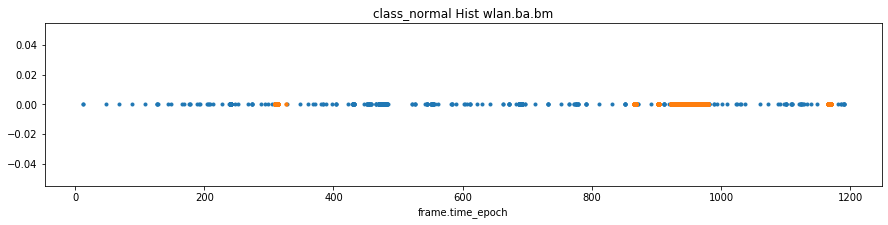

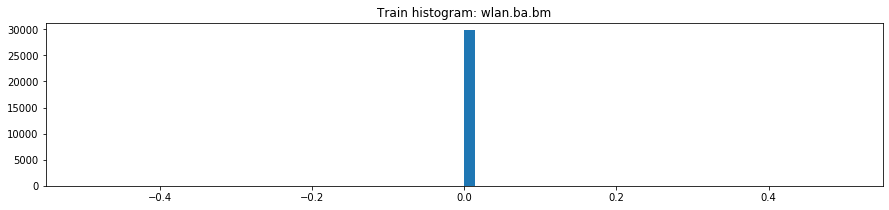

,wlan.ba.bm,Train,Train normal,Train not normal
0,count,29758.0,8851.0,20907.0
1,mean,0.0,0.0,0.0
2,std,0.0,0.0,0.0
3,min,0.0,0.0,0.0
4,25%,0.0,0.0,0.0
5,50%,0.0,0.0,0.0
6,75%,0.0,0.0,0.0
7,max,0.0,0.0,0.0
8,unique values,1.0,1.0,1.0
9,NaNs,0.0,0.0,0.0


,wlan.ba.bm,Count in train (desc),Mean target train,Sum target train
0,0,29758,0.297433,8851


,Column,Correlation with wlan.ba.bm
0,frame.time_delta,NaN
1,frame.time_relative,NaN
2,frame.len,NaN
3,radiotap.flags.cfp,NaN
4,wlan.fc.type_subtype,NaN
5,wlan.fc.type,NaN


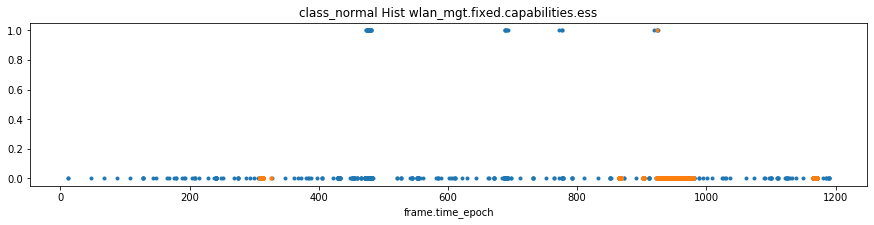

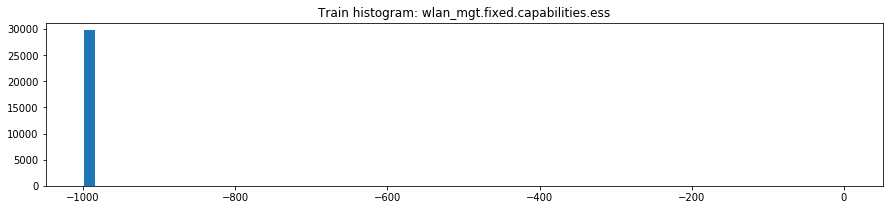

,wlan_mgt.fixed.capabilities.ess,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.000000
1,mean,-997.689428,-994.706700,-998.952169
2,std,36.178700,65.386167,6.915987
3,min,-999.000000,-999.000000,-999.000000
4,25%,-999.000000,-999.000000,-999.000000
5,50%,-999.000000,-999.000000,-999.000000
6,75%,-999.000000,-999.000000,-999.000000
7,max,1.000000,1.000000,1.000000
8,unique values,2.000000,2.000000,2.000000
9,NaNs,0.000000,0.000000,0.000000


,wlan_mgt.fixed.capabilities.ess,Count in train (desc),Mean target train,Sum target train
0,-999.0,29719,0.296544,8813
1,1.0,39,0.974359,38


,Column,Correlation with wlan_mgt.fixed.capabilities.ess
0,wlan_mgt.fixed.capabilities.ess,1.000000
1,wlan_mgt.fixed.aid,0.917233
2,wlan_mgt.fixed.status_code,0.329716
3,wlan.fc.type_subtype,0.239202
4,wlan_mgt.fixed.listen_ival,0.226315
5,wlan_mgt.fixed.beacon,0.226315
35,wlan.sa,-0.096802
36,frame.time_epoch,-0.112345
37,wlan.fc.type,-0.123506
38,wlan_mgt.ssid,-0.226315


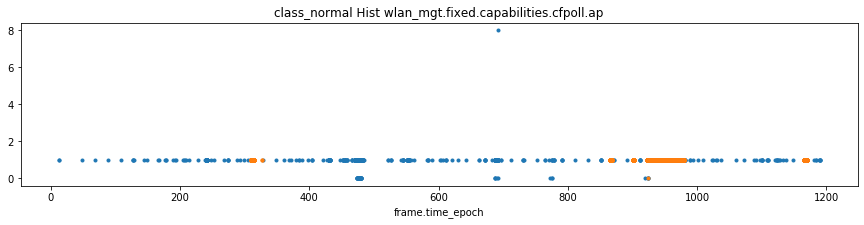

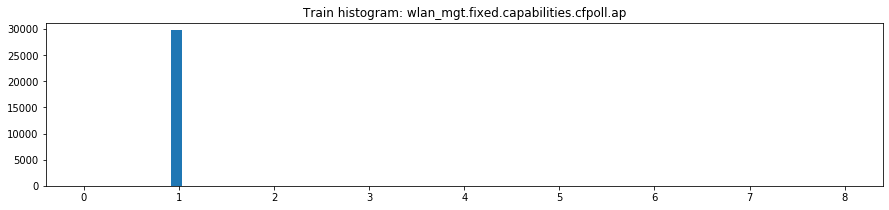

,wlan_mgt.fixed.capabilities.cfpoll.ap,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.000000
1,mean,0.998958,0.996611,0.999952
2,std,0.054061,0.098519,0.006916
3,min,0.000000,0.000000,0.000000
4,25%,1.000000,1.000000,1.000000
5,50%,1.000000,1.000000,1.000000
6,75%,1.000000,1.000000,1.000000
7,max,8.000000,8.000000,1.000000
8,unique values,3.000000,3.000000,2.000000
9,NaNs,0.000000,0.000000,0.000000


,wlan_mgt.fixed.capabilities.cfpoll.ap,Count in train (desc),Mean target train,Sum target train
0,1,29719,0.296544,8813
1,0,38,0.973684,37
2,8,1,1.000000,1


,Column,Correlation with wlan_mgt.fixed.capabilities.cfpoll.ap
0,wlan_mgt.fixed.capabilities.cfpoll.ap,1.000000
1,wlan_mgt.ssid,0.151495
2,wlan.fc.type,0.065698
3,frame.time_epoch,0.064217
4,wlan.sa,0.051012
5,wlan.ta_passed1second_count,0.047637
35,wlan_mgt.fixed.timestamp,-0.151495
36,wlan_mgt.fixed.listen_ival,-0.151495
37,wlan_mgt.fixed.status_code,-0.170168
38,wlan_mgt.fixed.aid,-0.484599


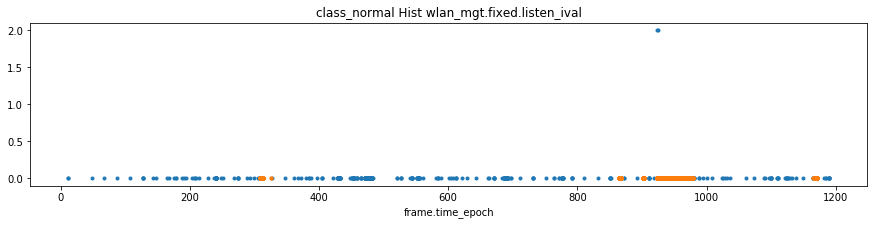

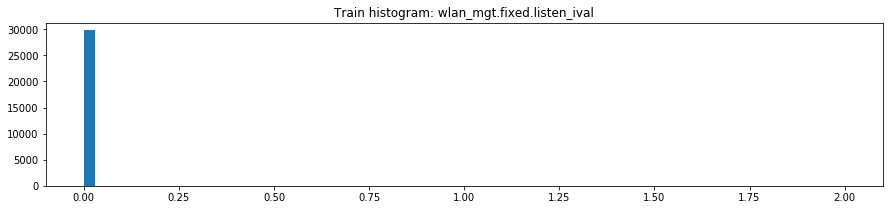

,wlan_mgt.fixed.listen_ival,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.0
1,mean,0.000134,0.000452,0.0
2,std,0.016396,0.030062,0.0
3,min,0.000000,0.000000,0.0
4,25%,0.000000,0.000000,0.0
5,50%,0.000000,0.000000,0.0
6,75%,0.000000,0.000000,0.0
7,max,2.000000,2.000000,0.0
8,unique values,2.000000,2.000000,1.0
9,NaNs,0.000000,0.000000,0.0


,wlan_mgt.fixed.listen_ival,Count in train (desc),Mean target train,Sum target train
0,0,29756,0.297385,8849
1,2,2,1.000000,2


,Column,Correlation with wlan_mgt.fixed.listen_ival
0,wlan_mgt.fixed.listen_ival,1.000000
1,wlan_mgt.fixed.current_ap,0.707095
2,wlan_mgt.fixed.capabilities.ess,0.226315
3,wlan.fc.type_subtype,0.058391
4,wlan.sa,0.037440
5,wlan.seq,0.013117
35,wlan.da_passed1second_count,-0.015195
36,wlan.ta_passed1second_count,-0.023677
37,wlan.fc.type,-0.027951
38,wlan_mgt.fixed.capabilities.cfpoll.ap,-0.151495


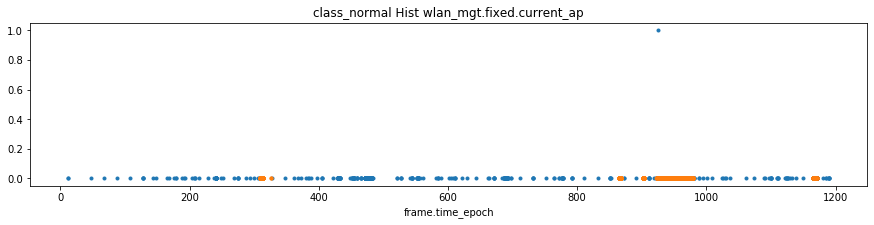

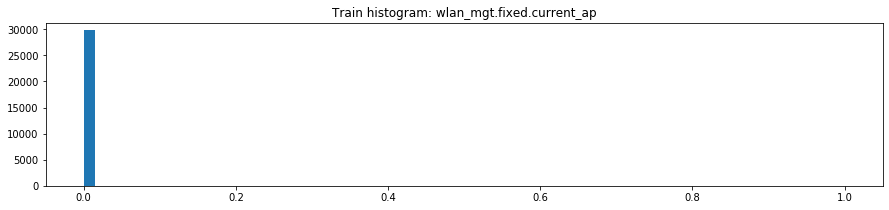

,wlan_mgt.fixed.current_ap,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.0
1,mean,0.000034,0.000113,0.0
2,std,0.005797,0.010629,0.0
3,min,0.000000,0.000000,0.0
4,25%,0.000000,0.000000,0.0
5,50%,0.000000,0.000000,0.0
6,75%,0.000000,0.000000,0.0
7,max,1.000000,1.000000,0.0
8,unique values,2.000000,2.000000,1.0
9,NaNs,0.000000,0.000000,0.0


,wlan_mgt.fixed.current_ap,Count in train (desc),Mean target train,Sum target train
0,0,29757,0.297409,8850
1,1,1,1.000000,1


,Column,Correlation with wlan_mgt.fixed.current_ap
0,wlan_mgt.fixed.current_ap,1.000000
1,wlan_mgt.fixed.listen_ival,0.707095
2,wlan_mgt.fixed.capabilities.ess,0.160026
3,wlan.fc.type_subtype,0.046623
4,wlan.sa,0.017968
5,wlan.seq,0.012763
35,wlan.da_passed1second_count,-0.010744
36,wlan.ta_passed1second_count,-0.016742
37,wlan.fc.type,-0.019764
38,wlan_mgt.fixed.capabilities.cfpoll.ap,-0.107121


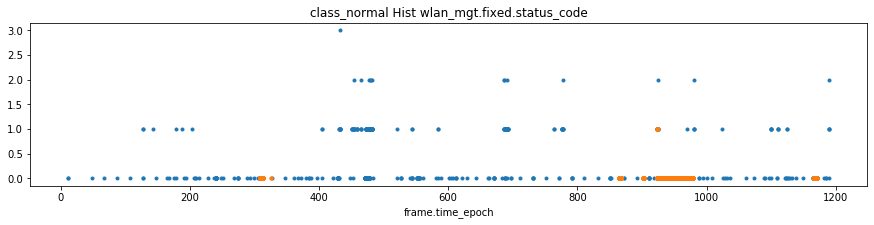

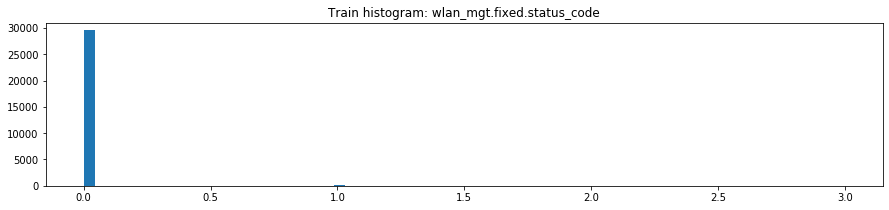

,wlan_mgt.fixed.status_code,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.000000
1,mean,0.008536,0.028019,0.000287
2,std,0.097664,0.175651,0.016939
3,min,0.000000,0.000000,0.000000
4,25%,0.000000,0.000000,0.000000
5,50%,0.000000,0.000000,0.000000
6,75%,0.000000,0.000000,0.000000
7,max,3.000000,3.000000,1.000000
8,unique values,4.000000,4.000000,2.000000
9,NaNs,0.000000,0.000000,0.000000


,wlan_mgt.fixed.status_code,Count in train (desc),Mean target train,Sum target train
0,0,29519,0.291948,8618
1,1,225,0.973333,219
2,2,13,1.000000,13
3,3,1,1.000000,1


,Column,Correlation with wlan_mgt.fixed.status_code
0,wlan_mgt.fixed.status_code,1.000000
1,wlan.fc.type_subtype,0.485044
2,wlan_mgt.fixed.aid,0.337321
3,wlan_mgt.fixed.capabilities.ess,0.329716
4,wlan.fc.subtype,0.189957
5,class_normal,0.129807
35,wlan.da_passed1second_count,-0.160228
36,wlan_mgt.fixed.capabilities.cfpoll.ap,-0.170168
37,wlan.ta_passed1second_count,-0.225054
38,frame.time_epoch,-0.268678


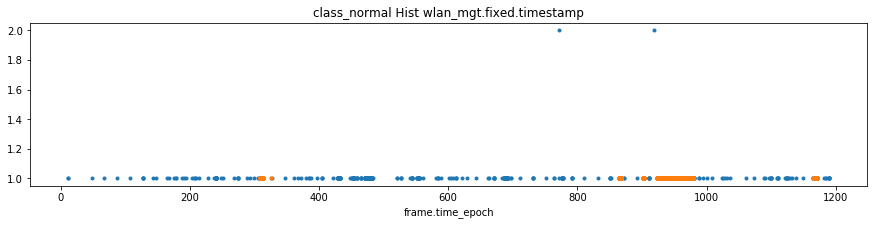

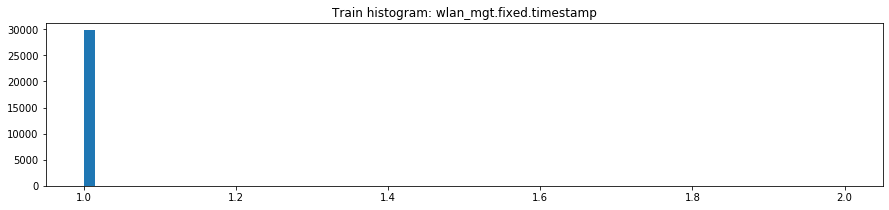

,wlan_mgt.fixed.timestamp,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.0
1,mean,1.000067,1.000226,1.0
2,std,0.008198,0.015031,0.0
3,min,1.000000,1.000000,1.0
4,25%,1.000000,1.000000,1.0
5,50%,1.000000,1.000000,1.0
6,75%,1.000000,1.000000,1.0
7,max,2.000000,2.000000,1.0
8,unique values,2.000000,2.000000,1.0
9,NaNs,0.000000,0.000000,0.0


,wlan_mgt.fixed.timestamp,Count in train (desc),Mean target train,Sum target train
0,1,29756,0.297385,8849
1,2,2,1.000000,2


,Column,Correlation with wlan_mgt.fixed.timestamp
0,wlan_mgt.fixed.timestamp,1.000000
1,wlan_mgt.fixed.beacon,1.000000
2,wlan_mgt.fixed.capabilities.ess,0.226315
3,frame.time_delta,0.034332
4,wlan.fc.subtype,0.014239
5,class_normal,0.012600
35,wlan.duration,-0.022242
36,wlan.sa,-0.022701
37,wlan.fc.type,-0.027951
38,wlan.fc.type_subtype,-0.039691


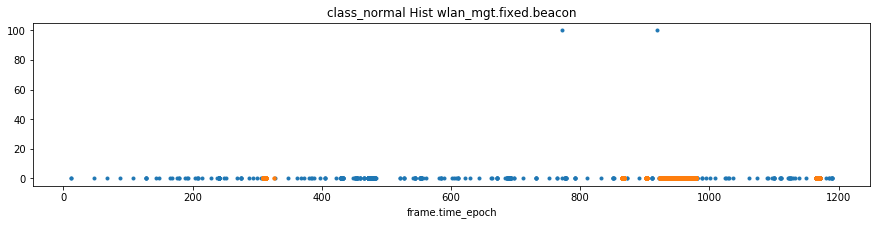

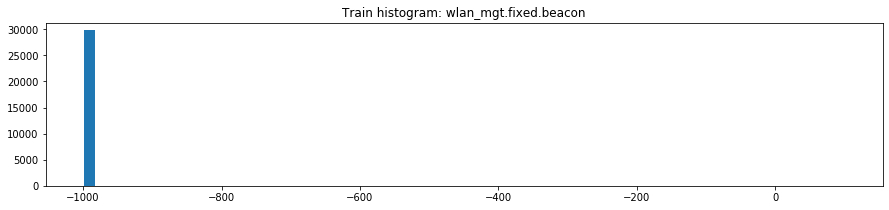

,wlan_mgt.fixed.beacon,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.0
1,mean,-998.926138,-998.751666,-999.0
2,std,9.009559,16.519313,0.0
3,min,-999.000000,-999.000000,-999.0
4,25%,-999.000000,-999.000000,-999.0
5,50%,-999.000000,-999.000000,-999.0
6,75%,-999.000000,-999.000000,-999.0
7,max,100.000000,100.000000,-999.0
8,unique values,2.000000,2.000000,1.0
9,NaNs,0.000000,0.000000,0.0


,wlan_mgt.fixed.beacon,Count in train (desc),Mean target train,Sum target train
0,-999.0,29756,0.297385,8849
1,100.0,2,1.000000,2


,Column,Correlation with wlan_mgt.fixed.beacon
0,wlan_mgt.fixed.beacon,1.000000
1,wlan_mgt.fixed.timestamp,1.000000
2,wlan_mgt.fixed.capabilities.ess,0.226315
3,frame.time_delta,0.034332
4,wlan.fc.subtype,0.014239
5,class_normal,0.012600
35,wlan.duration,-0.022242
36,wlan.sa,-0.022701
37,wlan.fc.type,-0.027951
38,wlan.fc.type_subtype,-0.039691


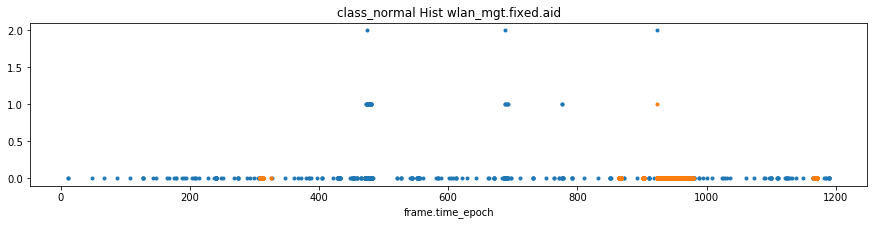

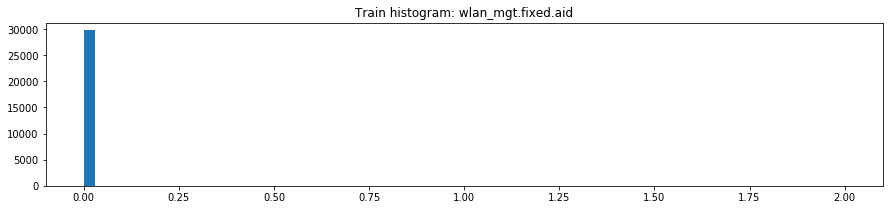

,wlan_mgt.fixed.aid,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.000000
1,mean,0.001277,0.004180,0.000048
2,std,0.038432,0.069579,0.006916
3,min,0.000000,0.000000,0.000000
4,25%,0.000000,0.000000,0.000000
5,50%,0.000000,0.000000,0.000000
6,75%,0.000000,0.000000,0.000000
7,max,2.000000,2.000000,1.000000
8,unique values,3.000000,3.000000,2.000000
9,NaNs,0.000000,0.000000,0.000000


,wlan_mgt.fixed.aid,Count in train (desc),Mean target train,Sum target train
0,0,29723,0.296639,8817
1,1,32,0.968750,31
2,2,3,1.000000,3


,Column,Correlation with wlan_mgt.fixed.aid
0,wlan_mgt.fixed.aid,1.000000
1,wlan_mgt.fixed.capabilities.ess,0.917233
2,wlan_mgt.fixed.status_code,0.337321
3,wlan.fc.type_subtype,0.239872
4,wlan.seq,0.066805
5,class_normal,0.049155
35,wlan.ta_passed1second_count,-0.081036
36,wlan.sa,-0.102267
37,frame.time_epoch,-0.109706
38,wlan.fc.type,-0.113284


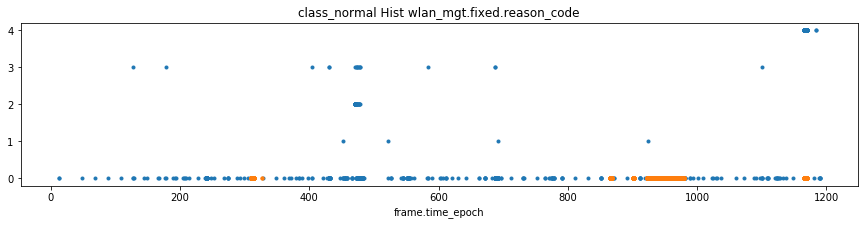

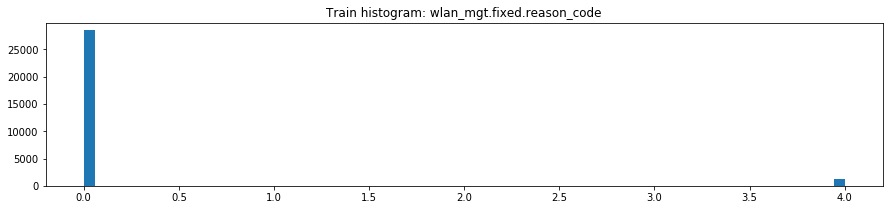

,wlan_mgt.fixed.reason_code,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.0
1,mean,0.168862,0.567732,0.0
2,std,0.799748,1.387114,0.0
3,min,0.000000,0.000000,0.0
4,25%,0.000000,0.000000,0.0
5,50%,0.000000,0.000000,0.0
6,75%,0.000000,0.000000,0.0
7,max,4.000000,4.000000,0.0
8,unique values,5.000000,5.000000,1.0
9,NaNs,0.000000,0.000000,0.0


,wlan_mgt.fixed.reason_code,Count in train (desc),Mean target train,Sum target train
0,0,28475,0.265777,7568
1,4,1223,1.000000,1223
2,2,39,1.000000,39
3,3,17,1.000000,17
4,1,4,1.000000,4


,Column,Correlation with wlan_mgt.fixed.reason_code
0,wlan_mgt.fixed.reason_code,1.000000
1,frame.time_relative,0.858623
2,wlan.fc.type_subtype,0.726906
3,wlan.seq,0.645552
4,wlan.fc.subtype,0.589591
5,frame.time_epoch,0.387463
35,wlan.da_passed1second_count,-0.196275
36,class_impersonation,-0.272850
37,wlan.ta_passed1second_count,-0.335672
38,wlan.sa,-0.575954


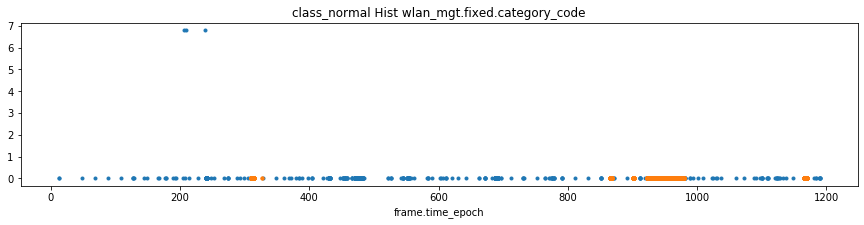

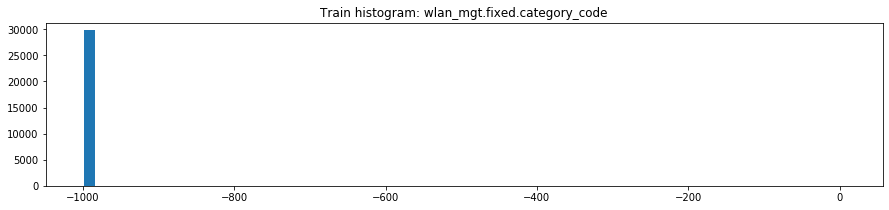

,wlan_mgt.fixed.category_code,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.0
1,mean,-998.898602,-998.659089,-999.0
2,std,10.098475,18.515140,0.0
3,min,-999.000000,-999.000000,-999.0
4,25%,-999.000000,-999.000000,-999.0
5,50%,-999.000000,-999.000000,-999.0
6,75%,-999.000000,-999.000000,-999.0
7,max,6.800000,6.800000,-999.0
8,unique values,2.000000,2.000000,1.0
9,NaNs,0.000000,0.000000,0.0


,wlan_mgt.fixed.category_code,Count in train (desc),Mean target train,Sum target train
0,-999.0,29755,0.297362,8848
1,6.8,3,1.000000,3


,Column,Correlation with wlan_mgt.fixed.category_code
0,wlan_mgt.fixed.htact,1.000000
1,wlan_mgt.fixed.category_code,1.000000
2,wlan.fc.type_subtype,0.080756
3,wlan.sa,0.035332
4,wlan.fc.subtype,0.030698
5,frame.time_delta,0.024528
35,wlan.da_passed1second_count,-0.018611
36,wlan.ra_passed1second_count,-0.018648
37,wlan.ta_passed1second_count,-0.028998
38,wlan.fc.type,-0.034234


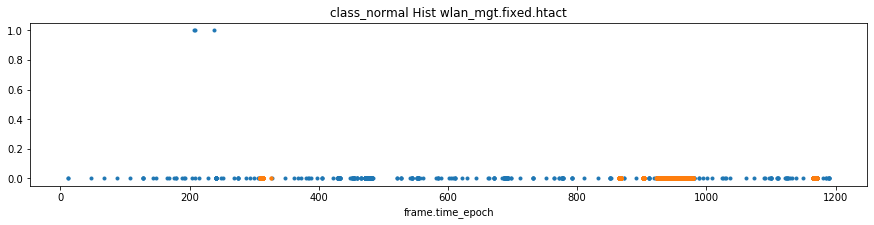

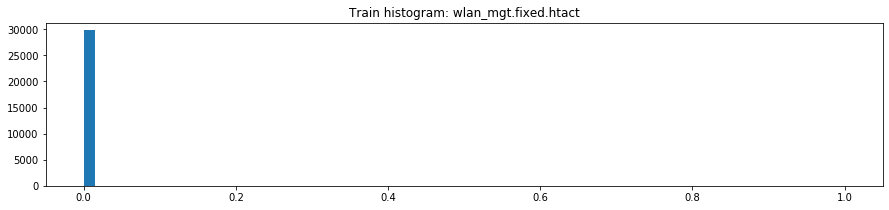

,wlan_mgt.fixed.htact,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.0
1,mean,0.000101,0.000339,0.0
2,std,0.010040,0.018408,0.0
3,min,0.000000,0.000000,0.0
4,25%,0.000000,0.000000,0.0
5,50%,0.000000,0.000000,0.0
6,75%,0.000000,0.000000,0.0
7,max,1.000000,1.000000,0.0
8,unique values,2.000000,2.000000,1.0
9,NaNs,0.000000,0.000000,0.0


,wlan_mgt.fixed.htact,Count in train (desc),Mean target train,Sum target train
0,0,29755,0.297362,8848
1,1,3,1.000000,3


,Column,Correlation with wlan_mgt.fixed.htact
0,wlan_mgt.fixed.category_code,1.000000
1,wlan_mgt.fixed.htact,1.000000
2,wlan.fc.type_subtype,0.080756
3,wlan.sa,0.035332
4,wlan.fc.subtype,0.030698
5,frame.time_delta,0.024528
35,wlan.da_passed1second_count,-0.018611
36,wlan.ra_passed1second_count,-0.018648
37,wlan.ta_passed1second_count,-0.028998
38,wlan.fc.type,-0.034234


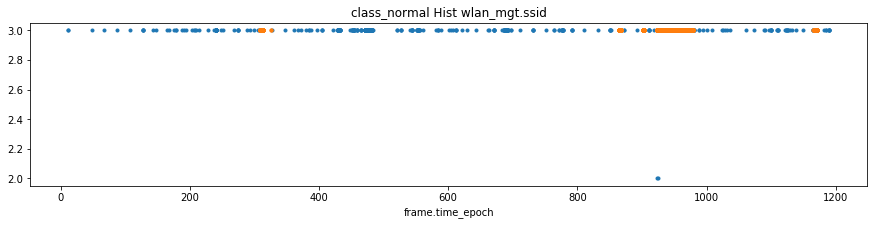

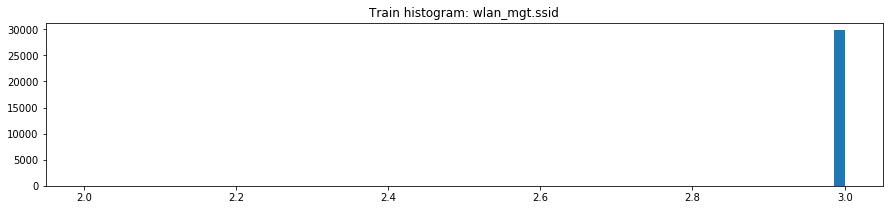

,wlan_mgt.ssid,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.0
1,mean,2.999933,2.999774,3.0
2,std,0.008198,0.015031,0.0
3,min,2.000000,2.000000,3.0
4,25%,3.000000,3.000000,3.0
5,50%,3.000000,3.000000,3.0
6,75%,3.000000,3.000000,3.0
7,max,3.000000,3.000000,3.0
8,unique values,2.000000,2.000000,1.0
9,NaNs,0.000000,0.000000,0.0


,wlan_mgt.ssid,Count in train (desc),Mean target train,Sum target train
0,3,29756,0.297385,8849
1,2,2,1.000000,2


,Column,Correlation with wlan_mgt.ssid
0,wlan_mgt.ssid,1.000000
1,wlan_mgt.fixed.capabilities.cfpoll.ap,0.151495
2,wlan.fc.type,0.027951
3,wlan.ta_passed1second_count,0.023677
4,wlan.da_passed1second_count,0.015195
5,class_impersonation,0.010594
35,wlan.sa,-0.037440
36,wlan.fc.type_subtype,-0.058391
37,wlan_mgt.fixed.capabilities.ess,-0.226315
38,wlan_mgt.fixed.current_ap,-0.707095


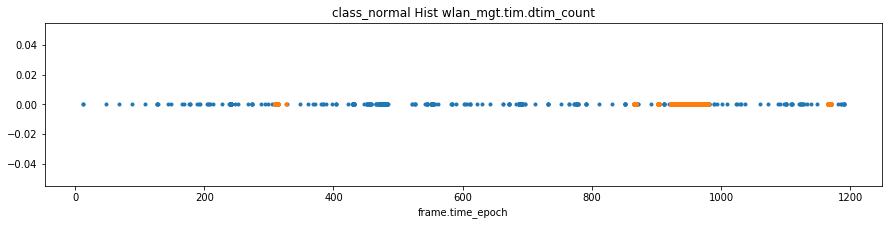

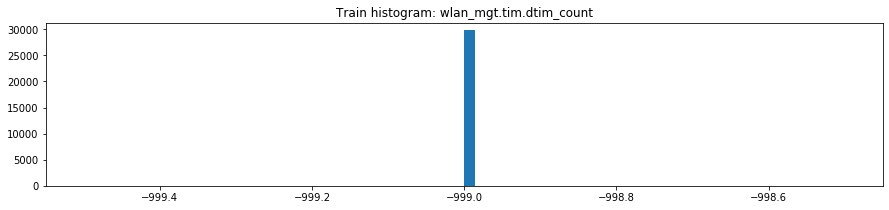

,wlan_mgt.tim.dtim_count,Train,Train normal,Train not normal
0,count,29758.0,8851.0,20907.0
1,mean,-999.0,-999.0,-999.0
2,std,0.0,0.0,0.0
3,min,-999.0,-999.0,-999.0
4,25%,-999.0,-999.0,-999.0
5,50%,-999.0,-999.0,-999.0
6,75%,-999.0,-999.0,-999.0
7,max,-999.0,-999.0,-999.0
8,unique values,1.0,1.0,1.0
9,NaNs,0.0,0.0,0.0


,wlan_mgt.tim.dtim_count,Count in train (desc),Mean target train,Sum target train
0,-999.0,29758,0.297433,8851


,Column,Correlation with wlan_mgt.tim.dtim_count
0,frame.time_delta,NaN
1,frame.time_relative,NaN
2,frame.len,NaN
3,radiotap.flags.cfp,NaN
4,wlan.fc.type_subtype,NaN
5,wlan.fc.type,NaN


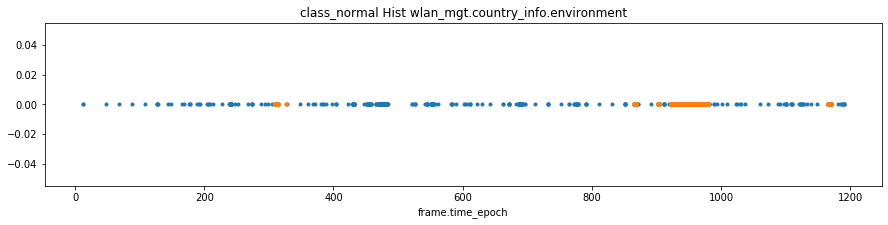

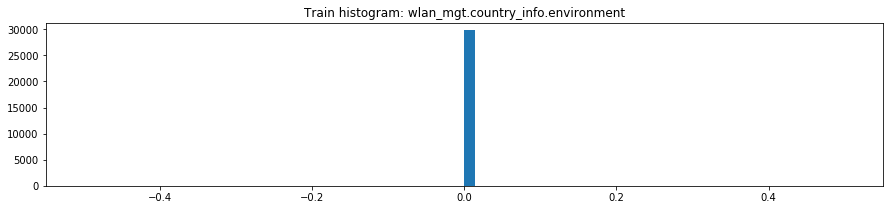

,wlan_mgt.country_info.environment,Train,Train normal,Train not normal
0,count,29758.0,8851.0,20907.0
1,mean,0.0,0.0,0.0
2,std,0.0,0.0,0.0
3,min,0.0,0.0,0.0
4,25%,0.0,0.0,0.0
5,50%,0.0,0.0,0.0
6,75%,0.0,0.0,0.0
7,max,0.0,0.0,0.0
8,unique values,1.0,1.0,1.0
9,NaNs,0.0,0.0,0.0


,wlan_mgt.country_info.environment,Count in train (desc),Mean target train,Sum target train
0,0,29758,0.297433,8851


,Column,Correlation with wlan_mgt.country_info.environment
0,frame.time_delta,NaN
1,frame.time_relative,NaN
2,frame.len,NaN
3,radiotap.flags.cfp,NaN
4,wlan.fc.type_subtype,NaN
5,wlan.fc.type,NaN


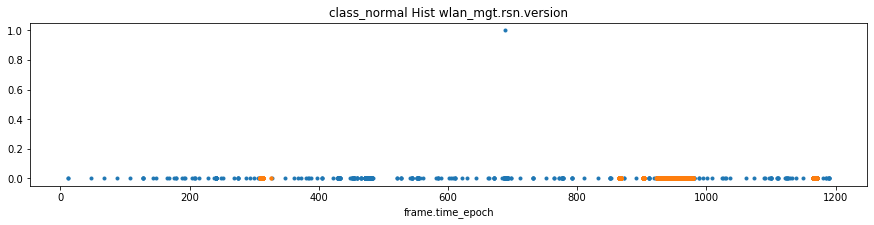

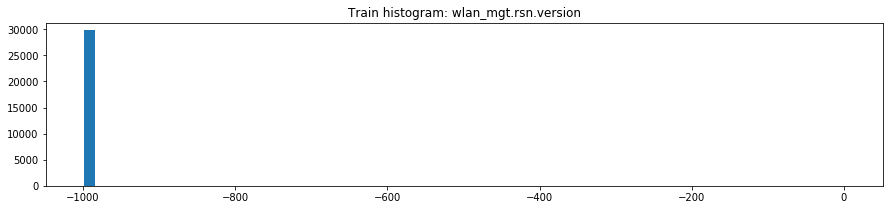

,wlan_mgt.rsn.version,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.0
1,mean,-998.966396,-998.887018,-999.0
2,std,5.796931,10.629280,0.0
3,min,-999.000000,-999.000000,-999.0
4,25%,-999.000000,-999.000000,-999.0
5,50%,-999.000000,-999.000000,-999.0
6,75%,-999.000000,-999.000000,-999.0
7,max,1.000000,1.000000,-999.0
8,unique values,2.000000,2.000000,1.0
9,NaNs,0.000000,0.000000,0.0


,wlan_mgt.rsn.version,Count in train (desc),Mean target train,Sum target train
0,-999.0,29757,0.297409,8850
1,1.0,1,1.000000,1


,Column,Correlation with wlan_mgt.rsn.version
0,wlan_mgt.rsn.version,1.000000
1,frame.time_delta,0.024276
2,wlan.sa,0.015538
3,class_normal,0.008910
4,frame.len,0.004189
5,wlan.fc.type,0.002078
35,wlan.bssid,-0.009178
36,wlan.da_passed1second_count,-0.010744
37,wlan.ra_passed1second_count,-0.010766
38,frame.time_epoch,-0.012946


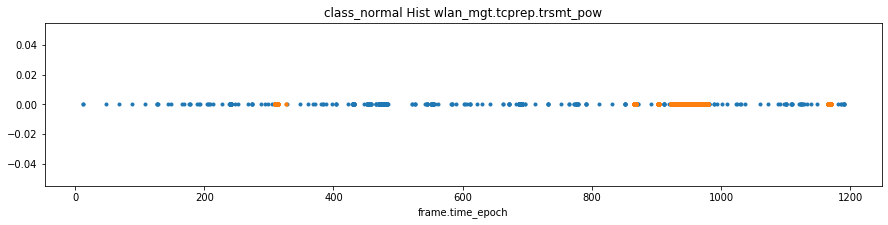

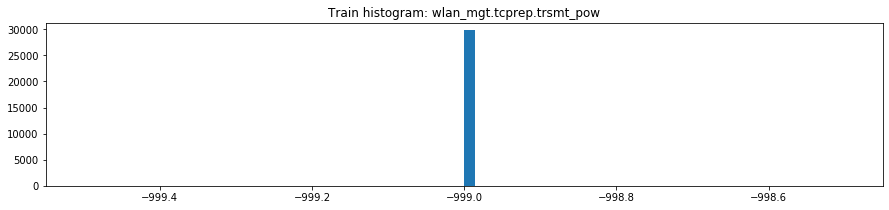

,wlan_mgt.tcprep.trsmt_pow,Train,Train normal,Train not normal
0,count,29758.0,8851.0,20907.0
1,mean,-999.0,-999.0,-999.0
2,std,0.0,0.0,0.0
3,min,-999.0,-999.0,-999.0
4,25%,-999.0,-999.0,-999.0
5,50%,-999.0,-999.0,-999.0
6,75%,-999.0,-999.0,-999.0
7,max,-999.0,-999.0,-999.0
8,unique values,1.0,1.0,1.0
9,NaNs,0.0,0.0,0.0


,wlan_mgt.tcprep.trsmt_pow,Count in train (desc),Mean target train,Sum target train
0,-999.0,29758,0.297433,8851


,Column,Correlation with wlan_mgt.tcprep.trsmt_pow
0,frame.time_delta,NaN
1,frame.time_relative,NaN
2,frame.len,NaN
3,radiotap.flags.cfp,NaN
4,wlan.fc.type_subtype,NaN
5,wlan.fc.type,NaN


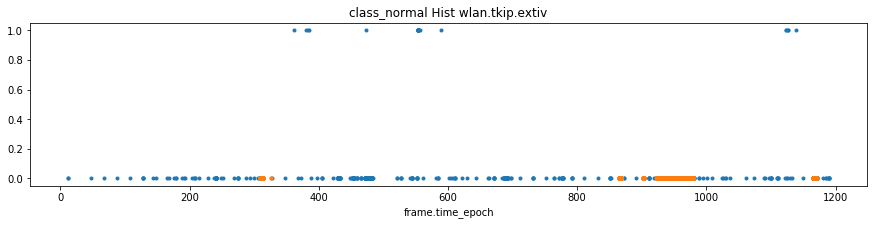

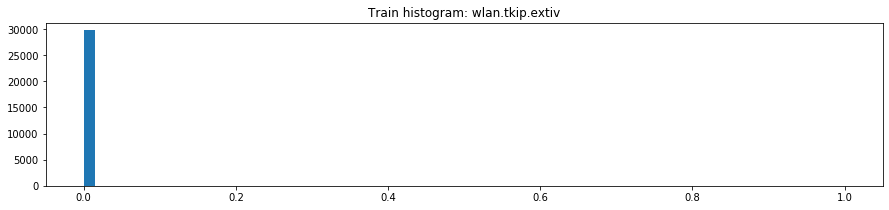

,wlan.tkip.extiv,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.0
1,mean,0.000807,0.002712,0.0
2,std,0.028388,0.052005,0.0
3,min,0.000000,0.000000,0.0
4,25%,0.000000,0.000000,0.0
5,50%,0.000000,0.000000,0.0
6,75%,0.000000,0.000000,0.0
7,max,1.000000,1.000000,0.0
8,unique values,2.000000,2.000000,1.0
9,NaNs,0.000000,0.000000,0.0


,wlan.tkip.extiv,Count in train (desc),Mean target train,Sum target train
0,0,29734,0.296866,8827
1,1,24,1.000000,24


,Column,Correlation with wlan.tkip.extiv
0,wlan.tkip.extiv,1.000000
1,wlan.bssid,0.208048
2,frame.time_delta,0.108158
3,class_normal,0.043665
4,wlan.fc.type,0.010184
5,frame.len,0.008358
35,wlan.wep.iv_passed1second_count,-0.050592
36,wlan.da_passed1second_count,-0.052593
37,wlan.ra_passed1second_count,-0.052712
38,frame.time_epoch,-0.075043


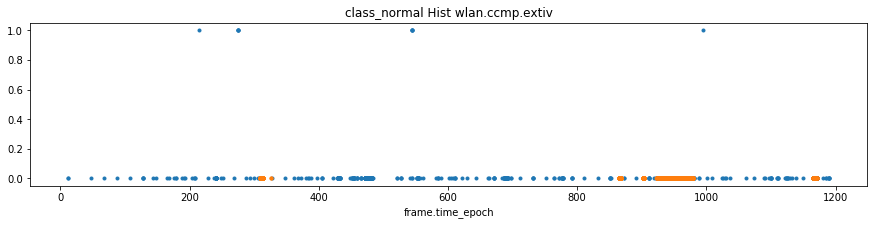

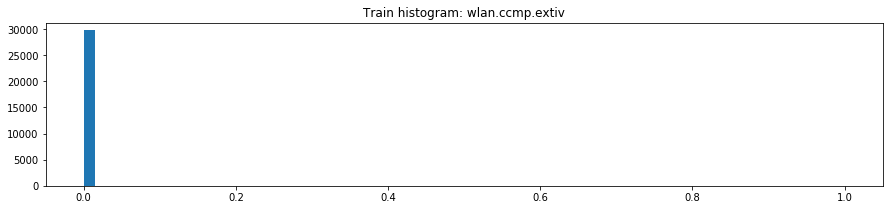

,wlan.ccmp.extiv,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.0
1,mean,0.000336,0.001130,0.0
2,std,0.018329,0.033596,0.0
3,min,0.000000,0.000000,0.0
4,25%,0.000000,0.000000,0.0
5,50%,0.000000,0.000000,0.0
6,75%,0.000000,0.000000,0.0
7,max,1.000000,1.000000,0.0
8,unique values,2.000000,2.000000,1.0
9,NaNs,0.000000,0.000000,0.0


,wlan.ccmp.extiv,Count in train (desc),Mean target train,Sum target train
0,0,29748,0.297196,8841
1,1,10,1.000000,10


,Column,Correlation with wlan.ccmp.extiv
0,wlan.ccmp.extiv,1.000000
1,wlan.bssid,0.073845
2,wlan.sa,0.039922
3,class_normal,0.028179
4,frame.time_delta,0.025204
5,wlan.fc.type,0.006572
35,wlan.wep.iv_passed1second_count,-0.030713
36,wlan.da_passed1second_count,-0.033982
37,wlan.ra_passed1second_count,-0.034051
38,wlan.ta_passed1second_count,-0.052949


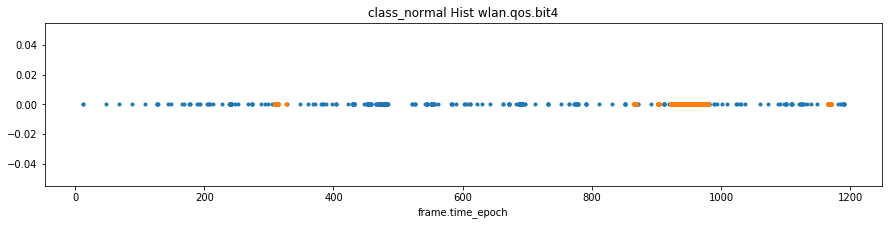

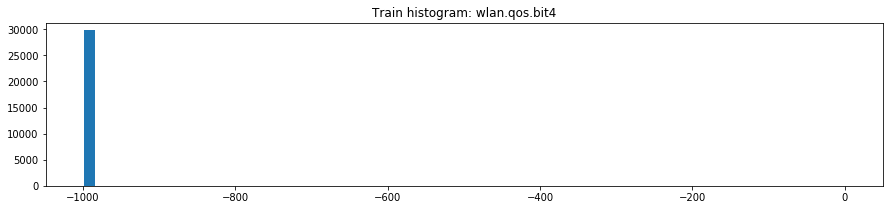

,wlan.qos.bit4,Train,Train normal,Train not normal
0,count,29758.000000,8851.0,20907.000000
1,mean,-998.966429,-999.0,-998.952217
2,std,5.791134,0.0,6.909071
3,min,-999.000000,-999.0,-999.000000
4,25%,-999.000000,-999.0,-999.000000
5,50%,-999.000000,-999.0,-999.000000
6,75%,-999.000000,-999.0,-999.000000
7,max,0.000000,-999.0,0.000000
8,unique values,2.000000,1.0,2.000000
9,NaNs,0.000000,0.0,0.000000


,wlan.qos.bit4,Count in train (desc),Mean target train,Sum target train
0,-999.0,29757,0.297443,8851
1,0.0,1,0.000000,0


,Column,Correlation with wlan.qos.bit4
0,wlan.qos.bit4,1.000000
1,class_injection,0.707095
2,wlan.seq,0.018068
3,wlan.fc.subtype,0.010068
4,wlan.fc.type,0.002078
5,frame.len,0.001521
35,wlan.duration,-0.013303
36,wlan.sa,-0.013622
37,wlan.ta_passed1second_count,-0.016371
38,wlan.fc.type_subtype,-0.017395


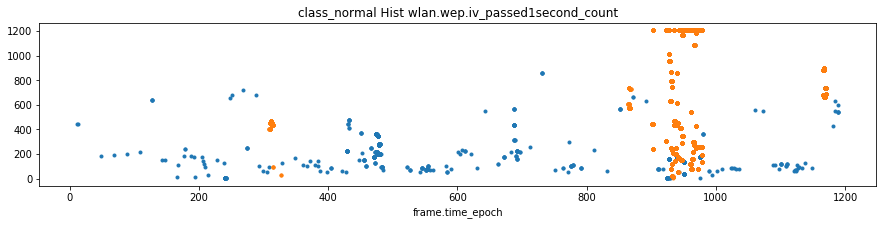

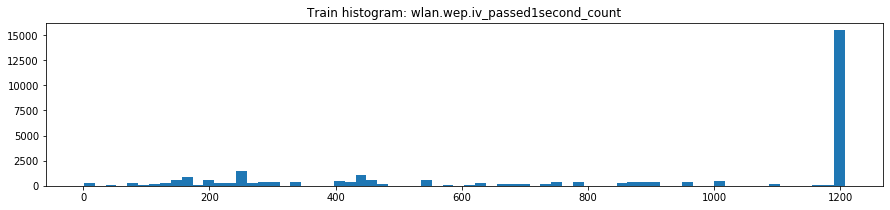

,wlan.wep.iv_passed1second_count,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.000000
1,mean,850.199341,760.169246,888.313675
2,std,424.445792,442.205589,410.807582
3,min,1.000000,1.000000,3.000000
4,25%,425.000000,273.000000,444.000000
5,50%,1207.000000,883.000000,1207.000000
6,75%,1207.000000,1207.000000,1207.000000
7,max,1207.000000,1207.000000,1207.000000
8,unique values,177.000000,167.000000,65.000000
9,NaNs,0.000000,0.000000,0.000000


,wlan.wep.iv_passed1second_count,Count in train (desc),Mean target train,Sum target train
0,1207.0,15465,0.231167,3575
1,544.0,544,0.264706,144
2,450.0,491,0.240326,118
3,1016.0,463,0.241901,112
4,439.0,450,0.268889,121
5,953.0,428,0.261682,112
6,425.0,425,0.242353,103
7,410.0,410,0.253659,104
8,867.0,392,0.272959,107
9,444.0,363,0.005510,2


,Column,Correlation with wlan.wep.iv_passed1second_count
0,wlan.wep.iv_passed1second_count,1.000000
1,wlan.ra_passed1second_count,0.590784
2,wlan.da_passed1second_count,0.565430
3,wlan.ta_passed1second_count,0.410892
4,frame.time_epoch,0.215730
5,class_impersonation,0.124240
35,wlan.sa,-0.110838
36,class_normal,-0.138014
37,wlan.ra_passed1second_count_change,-0.139238
38,frame.time_delta,-0.153431


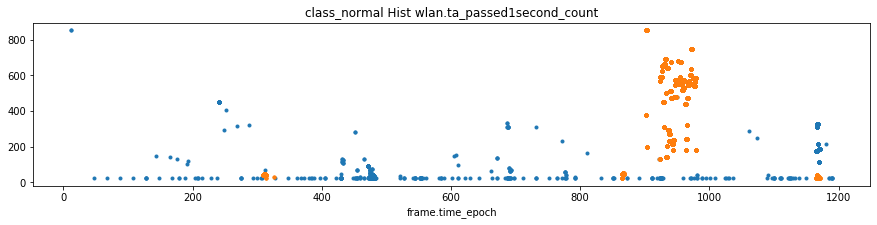

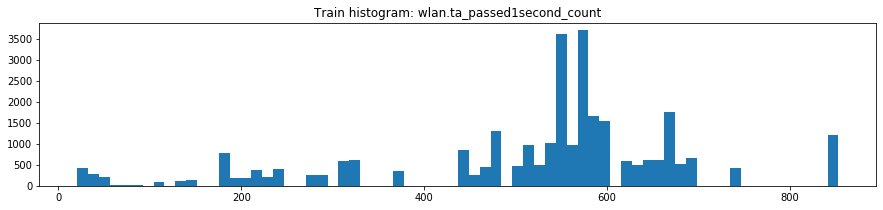

,wlan.ta_passed1second_count,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.000000
1,mean,518.518314,477.465032,535.898264
2,std,172.276607,182.076949,164.908830
3,min,21.000000,21.000000,21.000000
4,25%,474.000000,326.000000,498.000000
5,50%,554.000000,552.000000,561.000000
6,75%,593.000000,590.000000,601.000000
7,max,853.000000,853.000000,853.000000
8,unique values,123.000000,116.000000,71.000000
9,NaNs,0.000000,0.000000,0.000000


,wlan.ta_passed1second_count,Count in train (desc),Mean target train,Sum target train
0,853.0,1207,0.001657,2
1,568.0,1048,0.253817,266
2,552.0,1036,0.244208,253
3,693.0,666,0.247748,165
4,674.0,644,0.448758,289
5,666.0,640,0.267188,171
6,651.0,625,0.438400,274
7,642.0,616,0.246753,152
8,622.0,595,0.248739,148
9,593.0,572,0.256993,147


,Column,Correlation with wlan.ta_passed1second_count
0,wlan.ta_passed1second_count,1.000000
1,wlan.ra_passed1second_count,0.686687
2,wlan.da_passed1second_count,0.679638
3,wlan.wep.iv_passed1second_count,0.410892
4,wlan.fc.type,0.384152
5,wlan.ta_passed1second_count_change,0.364292
35,wlan.fc.type_subtype,-0.268177
36,wlan.fc.pwrmgt,-0.269212
37,wlan.seq,-0.320257
38,wlan_mgt.fixed.reason_code,-0.335672


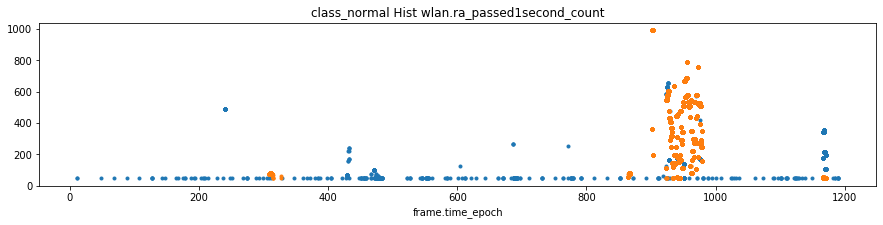

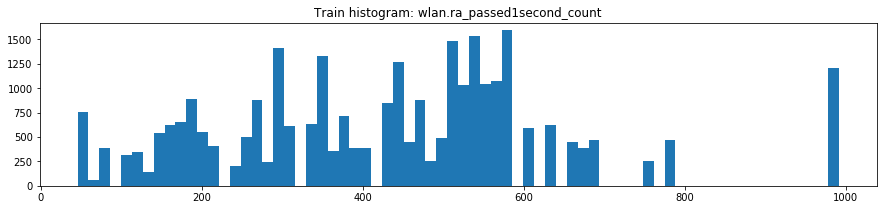

,wlan.ra_passed1second_count,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.000000
1,mean,431.282882,374.531465,455.308653
2,std,207.459480,183.035574,212.457240
3,min,46.000000,46.000000,46.000000
4,25%,278.000000,197.000000,295.000000
5,50%,445.000000,355.000000,473.000000
6,75%,547.000000,529.000000,564.000000
7,max,991.000000,787.000000,991.000000
8,unique values,111.000000,102.000000,82.000000
9,NaNs,0.000000,0.000000,0.000000


,wlan.ra_passed1second_count,Count in train (desc),Mean target train,Sum target train
0,509.0,1482,0.255061,378
1,991.0,1205,0.000000,0
2,580.0,1015,0.246305,250
3,473.0,873,0.247423,216
4,635.0,616,0.246753,152
5,604.0,594,0.247475,147
6,577.0,571,0.255692,146
7,564.0,557,0.256732,143
8,294.0,547,0.243144,133
9,546.0,544,0.264706,144


,Column,Correlation with wlan.ra_passed1second_count
0,wlan.ra_passed1second_count,1.000000
1,wlan.da_passed1second_count,0.973644
2,wlan.ta_passed1second_count,0.686687
3,wlan.wep.iv_passed1second_count,0.590784
4,wlan.ra_passed1second_count_change,0.253516
5,class_flooding,0.248339
35,class_normal,-0.177992
36,frame.time_delta,-0.195327
37,frame.time_relative,-0.225316
38,wlan.seq,-0.361816


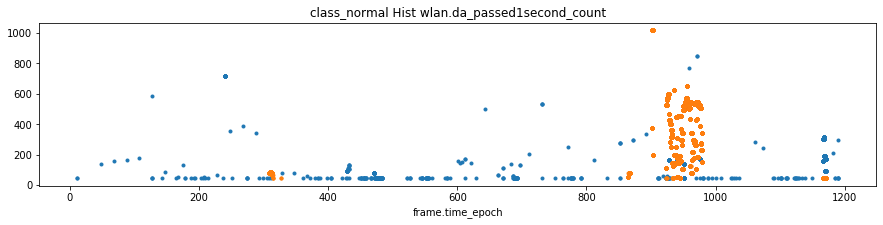

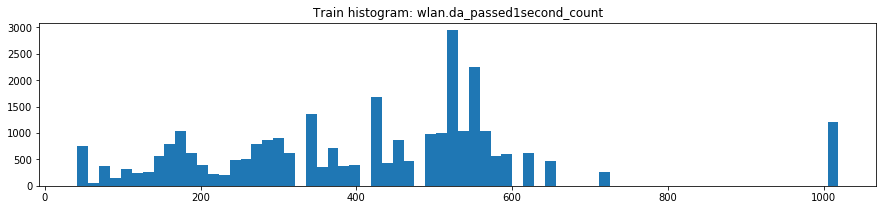

,wlan.da_passed1second_count,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.000000
1,mean,417.851300,363.015591,441.066054
2,std,202.788848,179.794801,207.454364
3,min,42.000000,42.000000,42.000000
4,25%,273.000000,187.000000,293.000000
5,50%,432.000000,345.000000,455.000000
6,75%,537.000000,526.000000,545.000000
7,max,1019.000000,851.000000,1019.000000
8,unique values,136.000000,126.000000,84.000000
9,NaNs,0.000000,0.000000,0.000000


,wlan.da_passed1second_count,Count in train (desc),Mean target train,Sum target train
0,1019.0,1205,0.000000,0
1,521.0,1027,0.242454,249
2,526.0,1018,0.243615,248
3,429.0,853,0.252052,215
4,315.0,630,0.619048,390
5,625.0,616,0.246753,152
6,599.0,594,0.247475,147
7,42.0,583,0.708405,413
8,575.0,571,0.255692,146
9,560.0,557,0.256732,143


,Column,Correlation with wlan.da_passed1second_count
0,wlan.da_passed1second_count,1.000000
1,wlan.ra_passed1second_count,0.973644
2,wlan.ta_passed1second_count,0.679638
3,wlan.wep.iv_passed1second_count,0.565430
4,class_flooding,0.297282
5,wlan.ra_passed1second_count_change,0.250478
35,wlan_mgt.fixed.reason_code,-0.196275
36,frame.time_relative,-0.263205
37,wlan.duration,-0.265794
38,wlan.seq,-0.426951


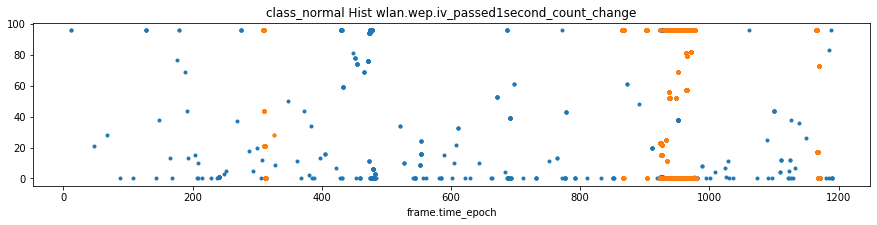

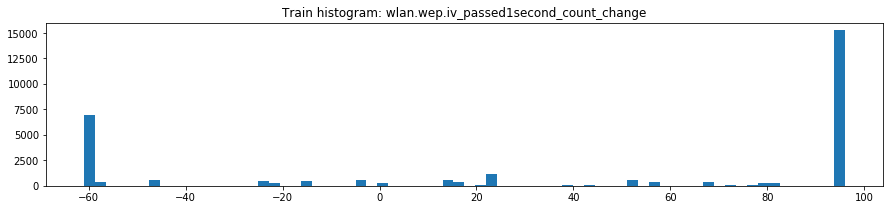

,wlan.wep.iv_passed1second_count_change,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.000000
1,mean,38.621749,37.224042,39.213469
2,std,67.366256,65.755552,68.029561
3,min,-61.000000,-61.000000,-61.000000
4,25%,-47.000000,-46.000000,-57.000000
5,50%,96.000000,76.000000,96.000000
6,75%,96.000000,96.000000,96.000000
7,max,96.000000,96.000000,96.000000
8,unique values,91.000000,91.000000,28.000000
9,NaNs,0.000000,0.000000,0.000000


,wlan.wep.iv_passed1second_count_change,Count in train (desc),Mean target train,Sum target train
0,96.0,15237,0.278795,4248
1,-61.0,6953,0.269812,1876
2,22.0,595,0.248739,148
3,52.0,594,0.244108,145
4,15.0,576,0.262153,151
5,23.0,562,0.259786,146
6,-16.0,519,0.236994,123
7,-23.0,516,0.250000,129
8,-4.0,415,0.260241,108
9,69.0,389,0.267352,104


,Column,Correlation with wlan.wep.iv_passed1second_count_change
0,wlan.wep.iv_passed1second_count_change,1.000000
1,wlan.ra_passed1second_count_change,0.785834
2,wlan.ta_passed1second_count_change,0.291818
3,wlan.ra_passed1second_count,0.234627
4,wlan.da_passed1second_count,0.231270
5,class_flooding,0.125880
35,wlan.wep.iv_passed1second_count,-0.070907
36,wlan.duration,-0.073069
37,wlan.sa,-0.074292
38,wlan.seq,-0.114040


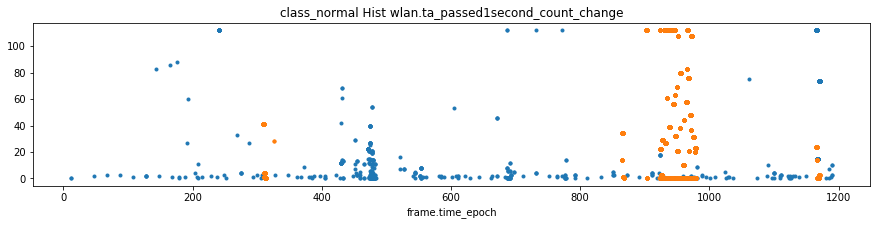

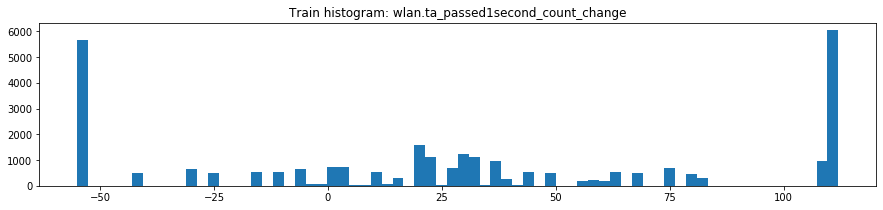

,wlan.ta_passed1second_count_change,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.000000
1,mean,29.285805,30.951870,28.580475
2,std,59.112046,58.464786,59.371243
3,min,-55.000000,-55.000000,-55.000000
4,25%,-16.000000,-10.000000,-26.000000
5,50%,27.000000,29.000000,27.000000
6,75%,80.000000,83.000000,80.000000
7,max,112.000000,112.000000,112.000000
8,unique values,83.000000,78.000000,46.000000
9,NaNs,0.000000,0.000000,0.000000


,wlan.ta_passed1second_count_change,Count in train (desc),Mean target train,Sum target train
0,112.0,6032,0.296751,1790
1,-55.0,5648,0.279391,1578
2,29.0,1222,0.346972,424
3,21.0,1057,0.285714,302
4,108.0,951,0.365931,348
5,27.0,676,0.258876,175
6,3.0,639,0.305164,195
7,-5.0,593,0.256324,152
8,22.0,588,0.292517,172
9,31.0,555,0.488288,271


,Column,Correlation with wlan.ta_passed1second_count_change
0,wlan.ta_passed1second_count_change,1.000000
1,wlan.ra_passed1second_count_change,0.461290
2,wlan.ta_passed1second_count,0.364292
3,wlan.wep.iv_passed1second_count_change,0.291818
4,wlan.da_passed1second_count,0.245462
5,wlan.ra_passed1second_count,0.242154
35,wlan.fc.type,-0.123842
36,class_impersonation,-0.136624
37,wlan.seq,-0.161508
38,wlan.duration,-0.202273


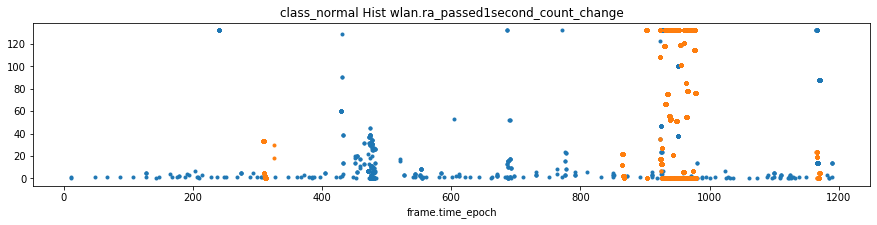

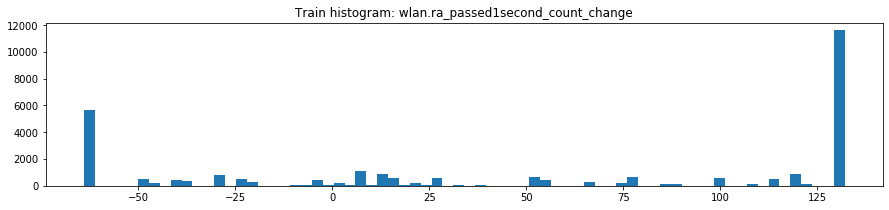

,wlan.ra_passed1second_count_change,Train,Train normal,Train not normal
0,count,29758.000000,8851.000000,20907.000000
1,mean,51.518818,53.165631,50.821639
2,std,80.121639,78.517007,80.783102
3,min,-64.000000,-64.000000,-64.000000
4,25%,-30.000000,-24.000000,-30.000000
5,50%,75.000000,76.000000,75.000000
6,75%,132.000000,132.000000,132.000000
7,max,132.000000,132.000000,132.000000
8,unique values,92.000000,88.000000,49.000000
9,NaNs,0.000000,0.000000,0.000000


,wlan.ra_passed1second_count_change,Count in train (desc),Mean target train,Sum target train
0,132.0,11599,0.294336,3414
1,-64.0,5659,0.278318,1575
2,27.0,602,0.257475,155
3,13.0,576,0.262153,151
4,17.0,565,0.267257,151
5,7.0,555,0.291892,162
6,6.0,513,0.265107,136
7,-48.0,510,0.249020,127
8,114.0,500,0.258000,129
9,-29.0,495,0.254545,126


,Column,Correlation with wlan.ra_passed1second_count_change
0,wlan.ra_passed1second_count_change,1.000000
1,wlan.wep.iv_passed1second_count_change,0.785834
2,wlan.ta_passed1second_count_change,0.461290
3,wlan.ra_passed1second_count,0.253516
4,wlan.da_passed1second_count,0.250478
5,wlan.ta_passed1second_count,0.169570
35,class_impersonation,-0.080944
36,wlan.duration,-0.116071
37,wlan.seq,-0.127182
38,wlan.wep.iv_passed1second_count,-0.139238


In [25]:
for col in columns:
    proc(df=X_test_bad, tcol='frame.time_epoch', target='class_normal', col=col, target_first=True, df_test=None, include_test=False)